# La présence de bibliothèques autour des lycées augmente-t-elle la performance des lycées ?

In [1]:
# Setup

# Si la commande n'avait pas déjà été lancée danas le terminal
!pip install -r "requirements.txt"

import numpy as np
import pandas as pd
import geopandas as gpd
from src.download_file import download_file
from src.data_lycees import get_data_lycees
from src.data_lycees import merge_data_lycees
from src.data_biblio import get_data_biblio
from src.calcul_biblio_rayons import calcul_biblio_rayons
from src.calcul_distance import calcul_distance
from src.classe_modelisation import PipelineRegression
import matplotlib.pyplot as plt
from plotnine import *
import folium

pd.set_option('display.width', 140)

### Contexte

La performance des lycées est ici entendue comme le taux de réussite à l’examen du 
baccalauréat général, même si l’étude du taux de mention obtenu par les lycées est 
une piste envisagée. Celle-ci peut être expliquée par trois facteurs :

-	par le public de l’établissement (les élèves et leur origine sociale)
-	par le contexte de l’établissement (ses propriétés intrinsèques et possiblement les politiques 
    éducatives dont il fait objet)
-	par l’environnement de l’établissement (ce qui est relatif à sa situation géographique)

La question que l’on se pose se concentre sur les facteurs environnementaux de réussite scolaire, 
en proposant l’analyse de l’impact de la présence de bibliothèques autour des lycées. Les 
bibliothèques, qu’elles soient municipales, universitaires ou d’une autre nature, sont en effet 
des lieux qui peuvent favoriser la réussite des élèves par au moins deux moyens : d’abord, ce 
sont des lieux d’accès à la culture et à la connaissance ; d’autre part, ce sont aussi des 
lieux de révision privilégiés, notamment pour la préparation du baccalauréat .

La démarche adoptée consiste donc principalement à étudier le lien entre proximité d’une (ou de) 
bibliothèque(s) et performance des lycées. Cette proximité sera évaluée par la distance 
géographique, ou aussi par le nombre d’équipements disponibles dans un rayon donné. 


##### Problématique :
Dès lors, la question centrale de ce projet est la suivante : la proximité des bibliothèques autour des lycées est-elle associée à de meilleures performances au baccalauréat général, toutes choses égales par ailleurs ?

L’objectif est ainsi d’évaluer dans quelle mesure la présence et le nombre de bibliothèques à proximité d’un lycée contribuent à expliquer les différences observées de performance scolaire, une fois contrôlés les facteurs sociaux et institutionnels.

### Méthodes

@bourdieuHeritiersEtudiantsCulture1964

Après quelques statistiques descriptives et cartes pour illustrer le problème, des régressions 
linéaires seront mobilisées pour tester notre hypothèse, en contrôlant par d’autres variables. En 
partant des facteurs mis en évidence précédemment, la composition sociale du lycée sera appréciée 
à partir de l’indice de position sociale proposée par la Depp (cf. rubrique « Données »). Le 
contexte de l’établissement sera surtout pris en compte par le secteur de l’établissement 
(privé / public) et les filières et formations disponibles en son sein (filières technologiques 
et professionnelles, formations post-baccalauréat comme les BTS ou CPGE).


### Données

Pour ce qui est des données mobilisées, l’échelle d’observation sera le lycée. Le champ d’étude 
est limité aux lycées avec au moins 50 candidats (seuil à préciser) présents aux épreuves du 
baccalauréat général en 2024. Il s’agira alors de construire nos observations à partir de 
trois bases de données ouvertes produites par la Depp (service statistique ministériel de 
l’Education nationale) :
-	taux de réussite et de mention au bac (https://data.education.gouv.fr/explore/dataset/fr-en-indicateurs-de-resultat-des-lycees-gt_v2/information/)
-	indice de position sociale (https://data.education.gouv.fr/explore/dataset/fr-en-ips-lycees-ap2023/information/)
-	géolocalisation des lycées (https://data.education.gouv.fr/explore/dataset/fr-en-adresse-et-geolocalisation-etablissements-premier-et-second-degre/information/)

Enfin, le choix de se limiter à 2024 est lié à la disponibilité des données concernant les 
bibliothèques. En effet, nous utilisons la base permanente des équipements, qui n’est disponible 
en open data que pour 2024 (https://www.data.gouv.fr/datasets/base-permanente-des-equipements-1/).


### Description des variables :
#### Description des variables expliquées :

1-Taux de réussite au baccalauréat général (taux_reu_gnle): Il s’agit du pourcentage d’élèves présents aux épreuves du baccalauréat général ayant obtenu le diplôme. Cette variable mesure la réussite minimale à l’examen.

2-Taux de mention au baccalauréat général (taux_men_gnle): Cette variable correspond au pourcentage d’élèves ayant obtenu une mention (Assez Bien, Bien ou Très Bien). Elle permet de capter une performance plus qualitative que le simple taux de réussite.

#### Description des variables explicatives principales :
1-Indice de position sociale (ips_voie_gt):

L’IPS mesure le niveau socio-économique moyen des élèves d’un lycée à partir des professions et catégories socioprofessionnelles des parents. Plus l’IPS est élevé, plus le public accueilli est socialement favorisé.

2-Nombre de bibliothèques à proximité (nb_biblio_500, nb_biblio_1000, nb_biblio_2000, nb_biblio_5000):

Ces variables mesurent le nombre de bibliothèques situées dans différents rayons autour de chaque lycée (500 mètres, 1 km, 2 km et 5 km). Elles ne sont pas directement disponibles dans les bases de données sources, mais sont construites par nous-mêmes à partir des coordonnées géographiques des lycées et des bibliothèques. Leur construction repose sur le calcul de distances géographiques entre chaque lycée et l’ensemble des bibliothèques recensées, puis sur le comptage du nombre d’équipements situés à l’intérieur de chaque rayon. Ces variables permettent de capter l’intensité de l’offre culturelle accessible à proximité immédiate des établissements scolaires.

3-Distance à la bibliothèque la plus proche (dist_proche_biblio_m):

Cette variable correspond à la distance géographique minimale, exprimée en mètres, entre un lycée et la bibliothèque la plus proche. Elle est entièrement construite dans le cadre de ce projet à partir des coordonnées GPS des établissements et des bibliothèques, en utilisant des méthodes de calcul de distance adaptées aux données géographiques. Contrairement aux variables de comptage, cette mesure fournit une approche continue de la proximité à l’équipement culturel le plus accessible.

4-Statut public ou privé (statut_public_prive):

Variable catégorielle indiquant si le lycée appartient au secteur public ou privé, afin de tenir compte des différences institutionnelles.

## Analyse descriptive des données

### Les données sur les lycées

In [2]:
# Importation des données sur les lycées

lycees_resultats, lycees_ips, annuaire_education = get_data_lycees()
lycees_data = merge_data_lycees(lycees_resultats, lycees_ips, annuaire_education)
lycees_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1911 entries, 0 to 2212
Data columns (total 45 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   uai                                 1911 non-null   object  
 1   annee                               1911 non-null   int64   
 2   presents_gnle                       1911 non-null   float64 
 3   taux_reu_gnle                       1911 non-null   float64 
 4   va_reu_gnle                         1910 non-null   float64 
 5   taux_men_gnle                       1911 non-null   float64 
 6   va_men_gnle                         1910 non-null   float64 
 7   ips_voie_gt                         1911 non-null   float64 
 8   ecart_type_voie_gt                  1911 non-null   float64 
 9   libelle_etablissement               1911 non-null   object  
 10  code_commune                        1911 non-null   object  
 11  code_departement           

/opt/python/lib/python3.13/site-packages/plotnine/layer.py:293: PlotnineWarning: stat_density : Removed 2 rows containing non-finite values.


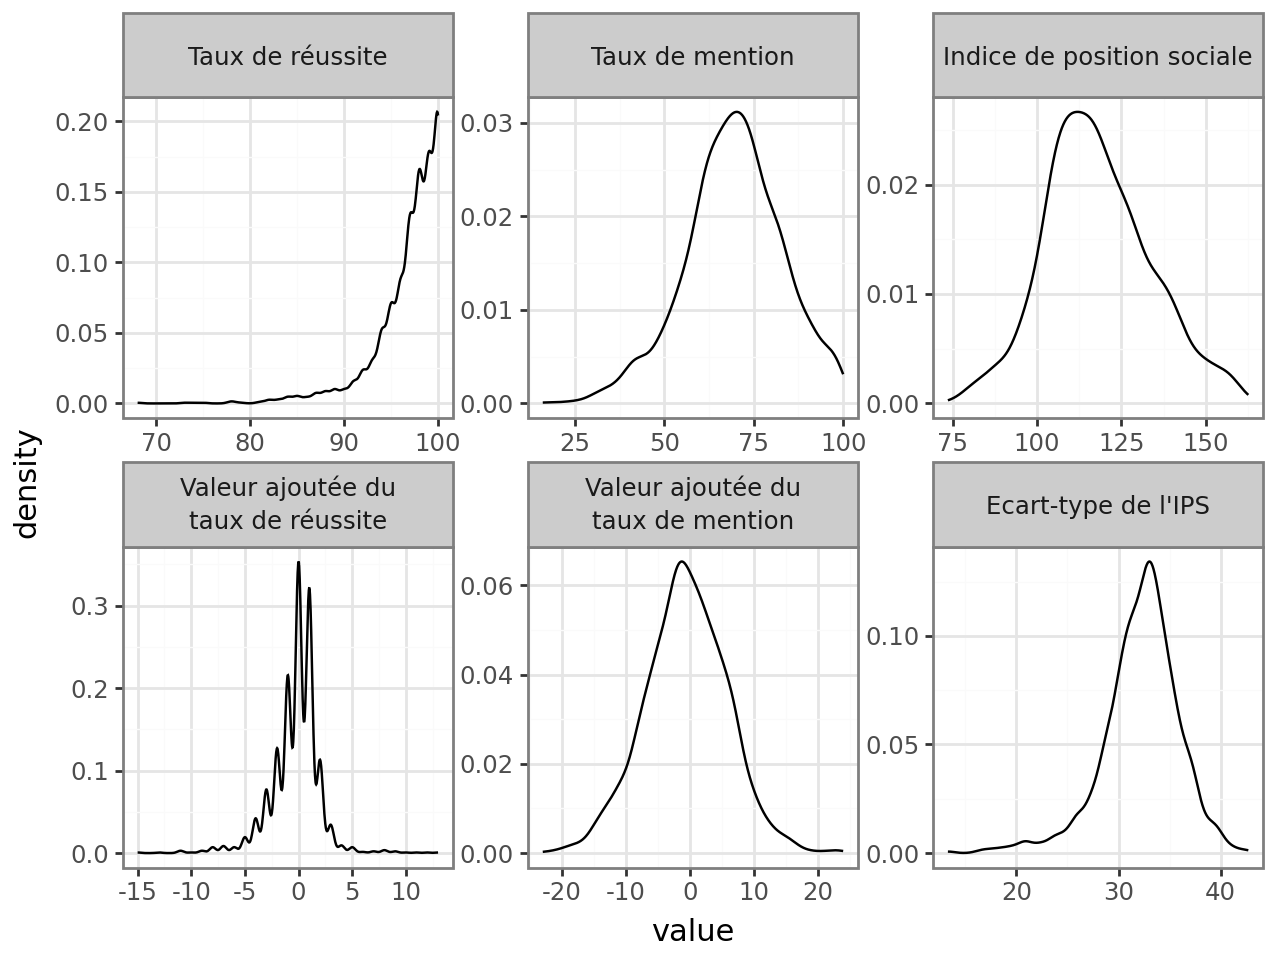

In [3]:
# Stats desc. - Lycées vars numériques

lycees_stat_desc_num = lycees_data.melt(
    id_vars = ['uai'],
    value_vars = [
        'taux_reu_gnle', 'va_reu_gnle', 'taux_men_gnle', 'va_men_gnle',
        'ips_voie_gt', 'ecart_type_voie_gt'
    ]
)#.sort_values('uai').reset_index()

lycees_stat_desc_num['variable'] = pd.Categorical(
    lycees_stat_desc_num['variable'],
    ordered=True,
    categories=[
        'taux_reu_gnle', 'taux_men_gnle', 'ips_voie_gt', 
        'va_reu_gnle', 'va_men_gnle', 'ecart_type_voie_gt'
    ]
).rename_categories([
    'Taux de réussite', 'Taux de mention', 
    'Indice de position sociale', 'Valeur ajoutée du\ntaux de réussite', 
    'Valeur ajoutée du\ntaux de mention', 'Ecart-type de l\'IPS'
])

(
    ggplot(lycees_stat_desc_num) +
    aes(x = 'value') +
    geom_density() +
    facet_wrap('variable', scales ='free') +
    theme_bw()
)

### 1-Densité du taux de réussite au baccalauréat général:
La densité du taux de réussite au baccalauréat général est fortement concentrée autour de valeurs élevées, avec un pic proche de 95–100 %. La distribution est peu dispersée et présente une asymétrie à gauche, traduisant un effet de plafond : la majorité des lycées atteignent un niveau de réussite élevé, tandis qu’un nombre restreint d’établissements affiche des performances nettement plus faibles. Cette faible variabilité limite le pouvoir discriminant du taux de réussite pour analyser les écarts de performance entre lycées, ce qui justifie le recours à des indicateurs plus exigeants, comme le taux de mention ou la valeur ajoutée.

### 2-Densité du taux de mention au baccalauréat général:
À l’inverse, la densité du taux de mention est beaucoup plus étalée et présente une dispersion marquée. La distribution est asymétrique à droite, indiquant que si une majorité de lycées obtient des taux de mention intermédiaires, une fraction non négligeable d’établissements se distingue par des performances très élevées. Cette hétérogénéité suggère que le taux de mention constitue une mesure plus fine de la performance scolaire et permet de mieux capter les différences de qualité entre établissements.



### Taux de mention au baccalauréat général selon le niveau social du lycée :

In [4]:
lycees_data["Quart_ips"]=pd.qcut(lycees_data["ips_voie_gt"], 4 ,labels=["Tres faible" , "Faible" , "Elevé" , "Tres Elevé"])
lycees_data["Quart_ips"].value_counts()

Quart_ips
Tres faible    481
Faible         478
Tres Elevé     478
Elevé          474
Name: count, dtype: int64

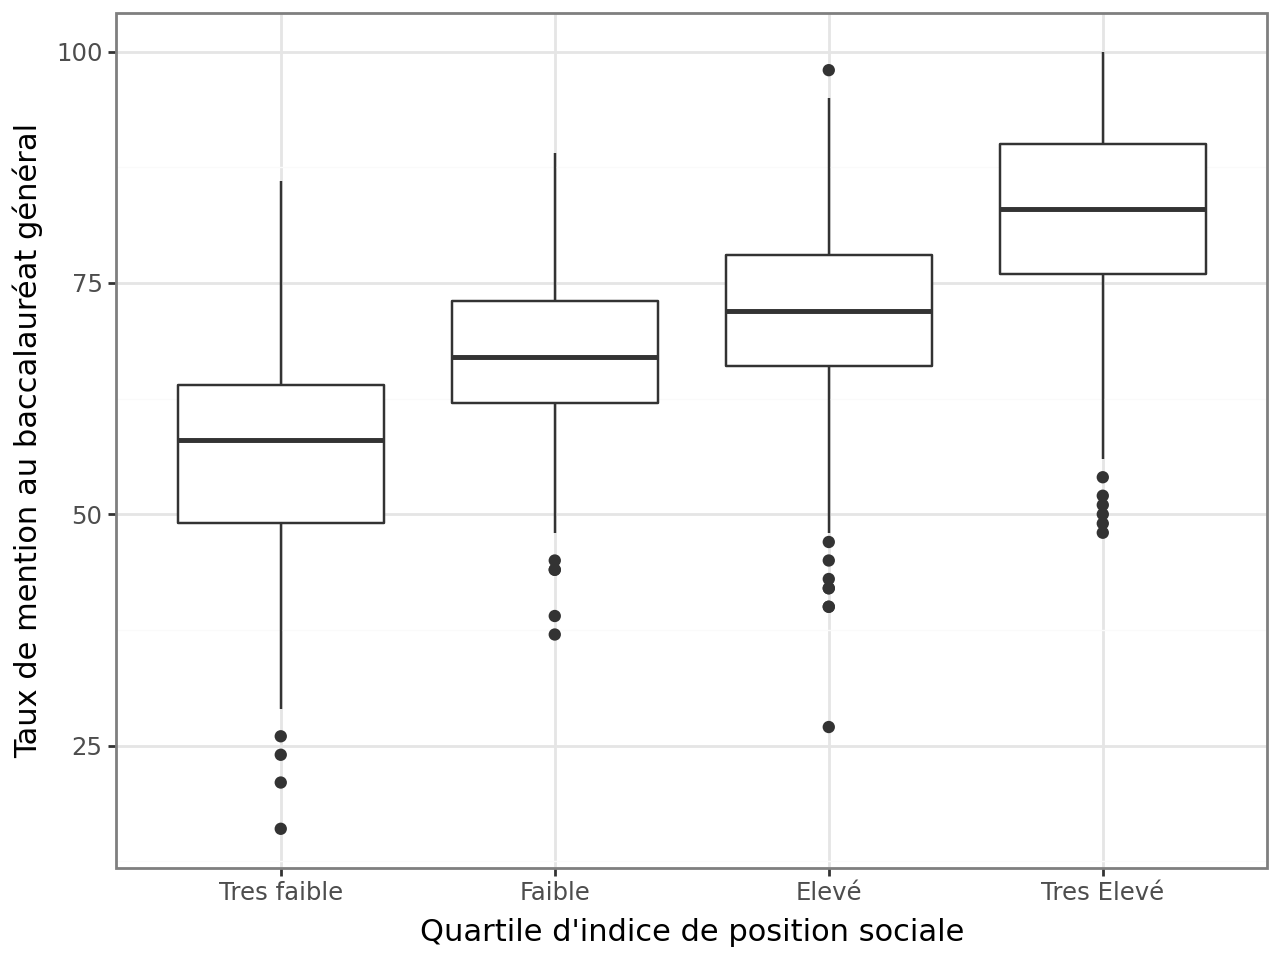

In [5]:
(
    ggplot(lycees_data) +
    aes(x="Quart_ips", y="taux_men_gnle") +
    geom_boxplot() +
    labs(
        x="Quartile d'indice de position sociale",
        y="Taux de mention au baccalauréat général"
    ) +
    theme_bw()
)

#### Interprétation

Le boxplot met en évidence une relation croissante très nette entre l’indice de position sociale et le taux de mention. Les lycées appartenant aux quartiles d’IPS les plus élevés présentent non seulement des taux de mention moyens plus importants, mais aussi une dispersion plus faible.

### Relation entre indice de position sociale et taux de mention

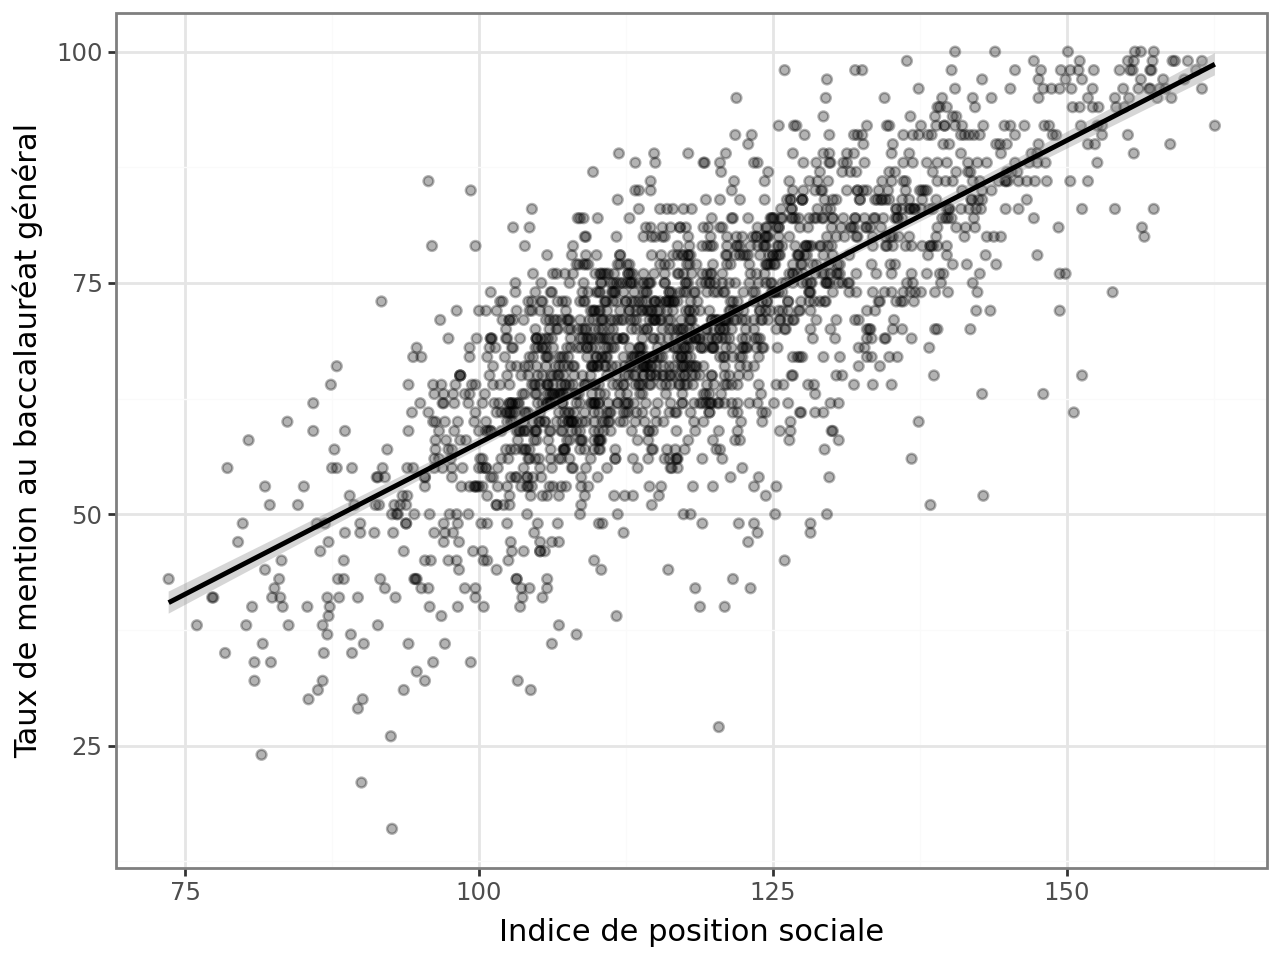

In [6]:
(
    ggplot(lycees_data) +
    aes(x="ips_voie_gt", y="taux_men_gnle") +
    geom_point(alpha=0.3) +
    geom_smooth(method="lm") +
    labs(
        x="Indice de position sociale",
        y="Taux de mention au baccalauréat général"
    ) +
    theme_bw()
)

#### Interpretation :
Le nuage de points met en évidence une relation positive quasi linéaire entre l’IPS et le taux de mention. La droite de régression suggère qu’une augmentation du niveau social moyen du lycée est associée à une amélioration significative de la performance qualitative au baccalauréat.

Cette relation justifie l’introduction systématique de l’IPS comme variable de contrôle dans les modèles.

### Les données sur les bibliothèques

In [7]:
# Importation des données sur les bibliothèques

biblio = get_data_biblio()
biblio.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4958 entries, 0 to 5166
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   NOMETAB           4958 non-null   object  
 1   PAYS              4958 non-null   object  
 2   CODEPOSTAL        4958 non-null   object  
 3   LATITUDE          4958 non-null   float64 
 4   LONGITUDE         4958 non-null   float64 
 5   CONDITIONACCES_d  4373 non-null   object  
 6   TYPEETABABES_d    4938 non-null   object  
 7   TYPEFAMABES_d     4936 non-null   object  
 8   TYPEINST_d        4957 non-null   object  
 9   geometry          4958 non-null   geometry
dtypes: float64(2), geometry(1), object(7)
memory usage: 426.1+ KB


### Croiser les données des lycées et des bibliothèques

Après avoir considéré séparément les données des lycées et des bibliothèques, il faut maintenant les
faire se rencontrer. Une première façon de le faire est de proposer une interprétation graphique du 
problème soulevé par ce projet. Pour cela, illustrons-le à l'aide d'une carte où sont représentés à
la fois les lycées et les bibliothèques. Par simplicité, nous nous concentrerons ici sur le cas de 
la ville de Paris.

In [8]:
# Carte lycées & bibliothèques

lycees_75 = lycees_data[lycees_data['code_departement'] == "075"]
biblio_75 = biblio[biblio['CODEPOSTAL'].str[0:2] == "75"]

center = [biblio_75.LATITUDE.mean(), biblio_75.LONGITUDE.mean()]
m = folium.Map(
    location=center, 
    zoom_start=12
    )

tooltip = folium.GeoJsonTooltip(
    fields=['NOMETAB', 'TYPEETABABES_d', 'CONDITIONACCES_d'],
    aliases=['Nom :', 'TYPEETABABES : ', 'CONDITIONACCES_d :'],
    localize=True
)
folium.GeoJson(
    biblio_75,
    tooltip=tooltip, 
    marker=folium.Marker(icon=folium.Icon(color="green")),
).add_to(m)

tooltip = folium.GeoJsonTooltip(
    fields=['libelle_etablissement', 'statut_public_prive', 'presents_gnle', 'taux_reu_gnle', 'taux_men_gnle', 'ips_voie_gt'],
    aliases=[
        'Nom :', 'Secteur :', 'Nombre de candidats présents :', 'Taux de réussite :', 'Taux de mention',
        'Indice de position sociale :'
    ],
    localize=True
)
folium.GeoJson(
    lycees_75,
    tooltip=tooltip, 
    marker=folium.Marker(icon=folium.Icon(color="blue")),
).add_to(m)

m

interprétation de la carte

In [9]:
# Calculs - Distance à la bibliothèque la plus proche

lycees_data = calcul_distance(lycees_data, biblio)


La distance à la bibliothèque la plus proche

[np.float64(0.0), np.float64(0.1), np.float64(0.2), np.float64(0.30000000000000004), np.float64(0.4), np.float64(0.5), np.float64(0.6000000000000001), np.float64(0.7000000000000001), np.float64(0.8), np.float64(0.9), np.float64(1.0)]
[    0   179   281   381   495   653   845  1073  1474  3619 38873]


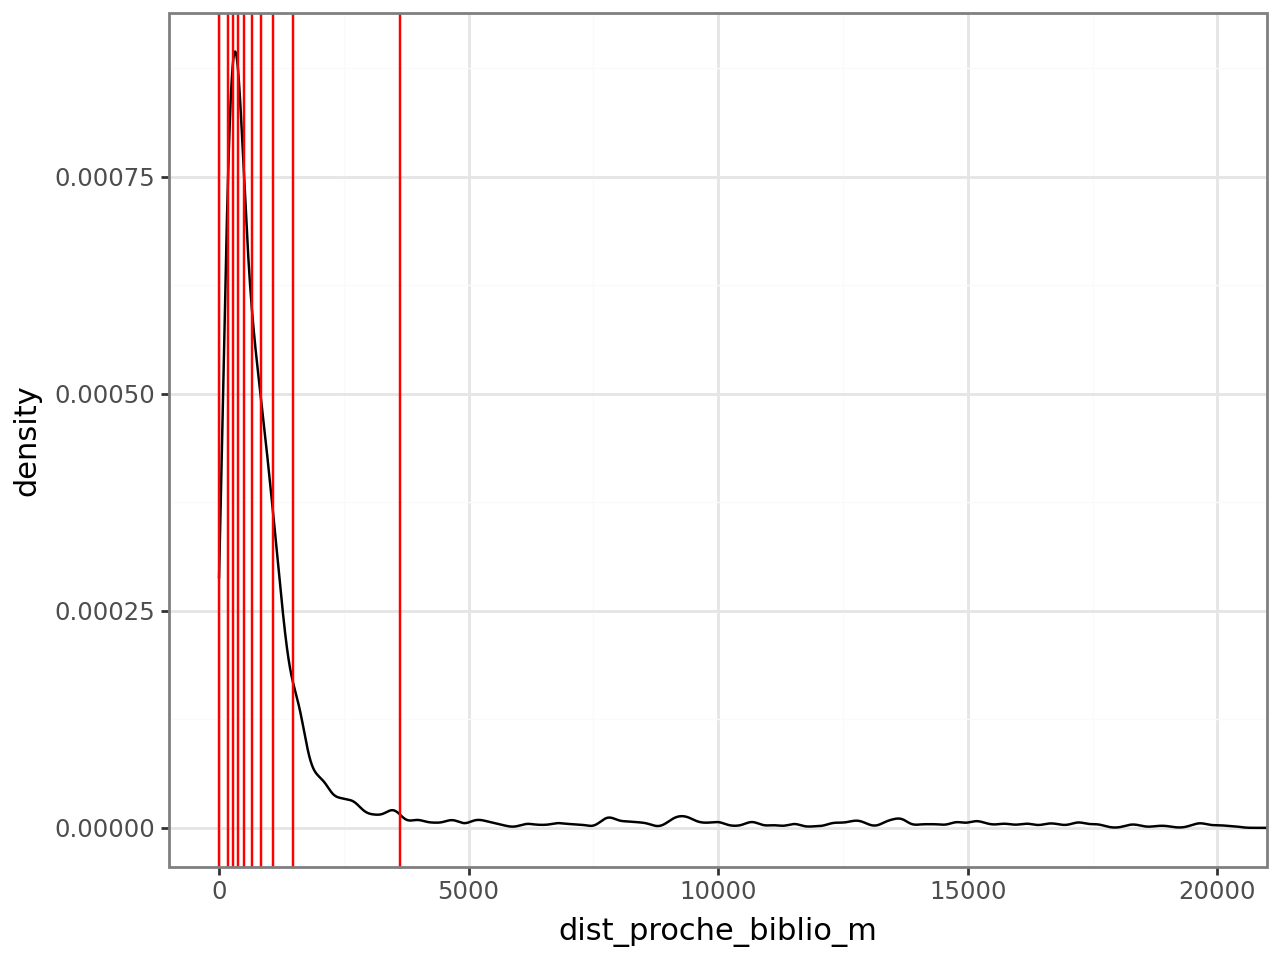

In [10]:
# Stats desc. - Distance à la bibliothèque la plus proche

probs = list(np.arange(0, 1.1, 0.1))
temp_quantile = np.quantile(lycees_data['dist_proche_biblio_m'], q = probs)
temp_quantile = np.quantile(lycees_data['dist_proche_biblio_m'], q = probs)
print(probs)
print(temp_quantile.round().astype(int))
(
    ggplot(lycees_data) +
    geom_density(aes(x = 'dist_proche_biblio_m'), n = 10000) + 
    coord_cartesian(xlim = [0, 20000]) +
    geom_vline(xintercept=temp_quantile.tolist(), color="red") +
    theme_bw()
)

#### Interpretation : 
La distribution de la distance à la bibliothèque la plus proche est fortement asymétrique à droite. La majorité des lycées disposent d’une bibliothèque à une distance relativement faible, tandis qu’un nombre restreint d’établissements se situe dans des zones nettement moins bien équipées.

Les quantiles indiquent notamment que 50 % des lycées se trouvent à moins d’environ 650 mètres d’une bibliothèque, ce qui suggère un accès relativement généralisé, mais inégal, aux équipements culturels.

In [11]:
# Calculs - Présence et nombre de bibliothèques à proximité

lycees_data = calcul_biblio_rayons(lycees_data, biblio)

lycees_data = lycees_data.assign(
    dummy_biblio_500 = lycees_data['nb_biblio_500'] > 0,
    dummy_biblio_1000 = lycees_data['nb_biblio_1000'] > 0,
    dummy_biblio_2000 = lycees_data['nb_biblio_2000'] > 0,
    dummy_biblio_5000 = lycees_data['nb_biblio_5000'] > 0,
)


La présence et le nombre de bibliothèques à proximité

In [12]:
# Stats desc. - Présence et nombre de bibliothèques à proximité

(
    lycees_data
    .groupby(['dummy_biblio_500', 'dummy_biblio_1000', 'dummy_biblio_2000', 'dummy_biblio_5000'])
    .size()
    .div(lycees_data.shape[0])
    .mul(100)
)

dummy_biblio_500  dummy_biblio_1000  dummy_biblio_2000  dummy_biblio_5000
False             False              False              False                 9.035840
                                                        True                  5.451792
                                     True               True                 18.677436
                  True               True               True                 26.400808
True              True               True               True                 40.434124
dtype: float64

In [13]:
# Stats desc. - Présence et nombre de bibliothèques à proximité

pd.crosstab(
    lycees_data['libelle_region'],
    lycees_data['dummy_biblio_5000']
    )

dummy_biblio_5000           False  True 
libelle_region                          
Auvergne-Rhône-Alpes           38    230
Bourgogne-Franche-Comté         2     80
Bretagne                       17     87
Centre-Val de Loire             1     60
Grand Est                      10    160
Hauts-de-France                10    157
Ile-de-France                  11    424
Normandie                       7     87
Nouvelle-Aquitaine             24    141
Occitanie                      25    144
Pays de la Loire               28     91
Provence-Alpes-Côte d'Azur      6    141

#### Taux de mention selon présence d’une bibliothèque à 500 m :

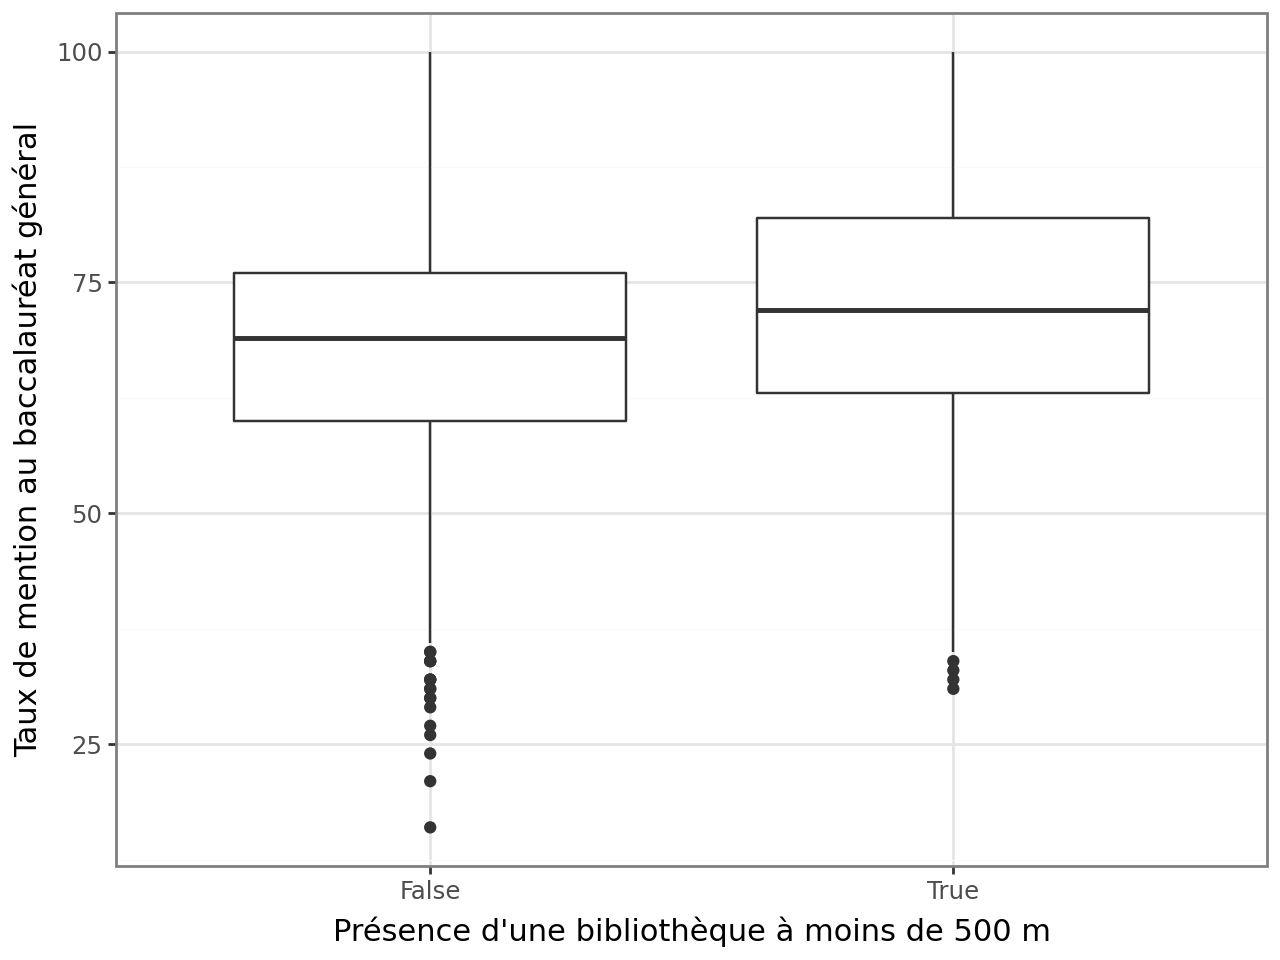

In [14]:
(
    ggplot(lycees_data) +
    aes(x="dummy_biblio_500", y="taux_men_gnle") +
    geom_boxplot() +
    labs(
        x="Présence d'une bibliothèque à moins de 500 m",
        y="Taux de mention au baccalauréat général"
    ) +
    theme_bw()
)

#### Interpretation :
Les lycées disposant d’au moins une bibliothèque à moins de 500 mètres présentent un taux de mention médian plus élevé que ceux n’ayant aucun équipement à proximité immédiate.

Cet écart suggère un lien positif entre l’accès à une bibliothèque et la performance scolaire, bien que cette observation descriptive ne permette pas d’identifier un effet causal.

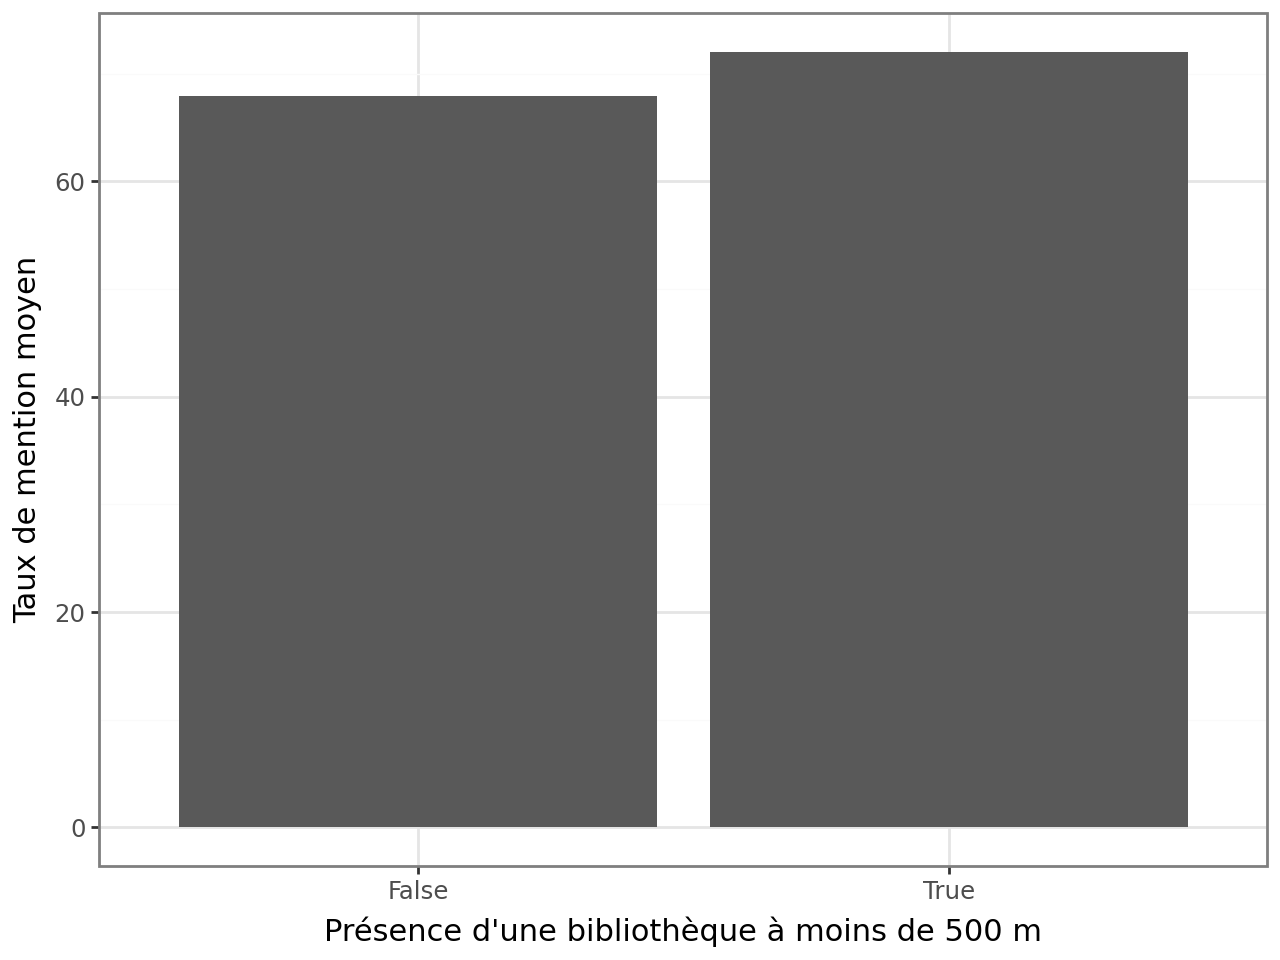

In [15]:
mean_biblio = (
    lycees_data
    .groupby("dummy_biblio_500")["taux_men_gnle"]
    .mean()
    .reset_index()
)

(
    ggplot(mean_biblio) +
    aes(x="dummy_biblio_500", y="taux_men_gnle") +
    geom_col() +
    labs(
        x="Présence d'une bibliothèque à moins de 500 m",
        y="Taux de mention moyen"
    ) +
    theme_bw()
)

#### Distance à la bibliothèque et taux de mention :

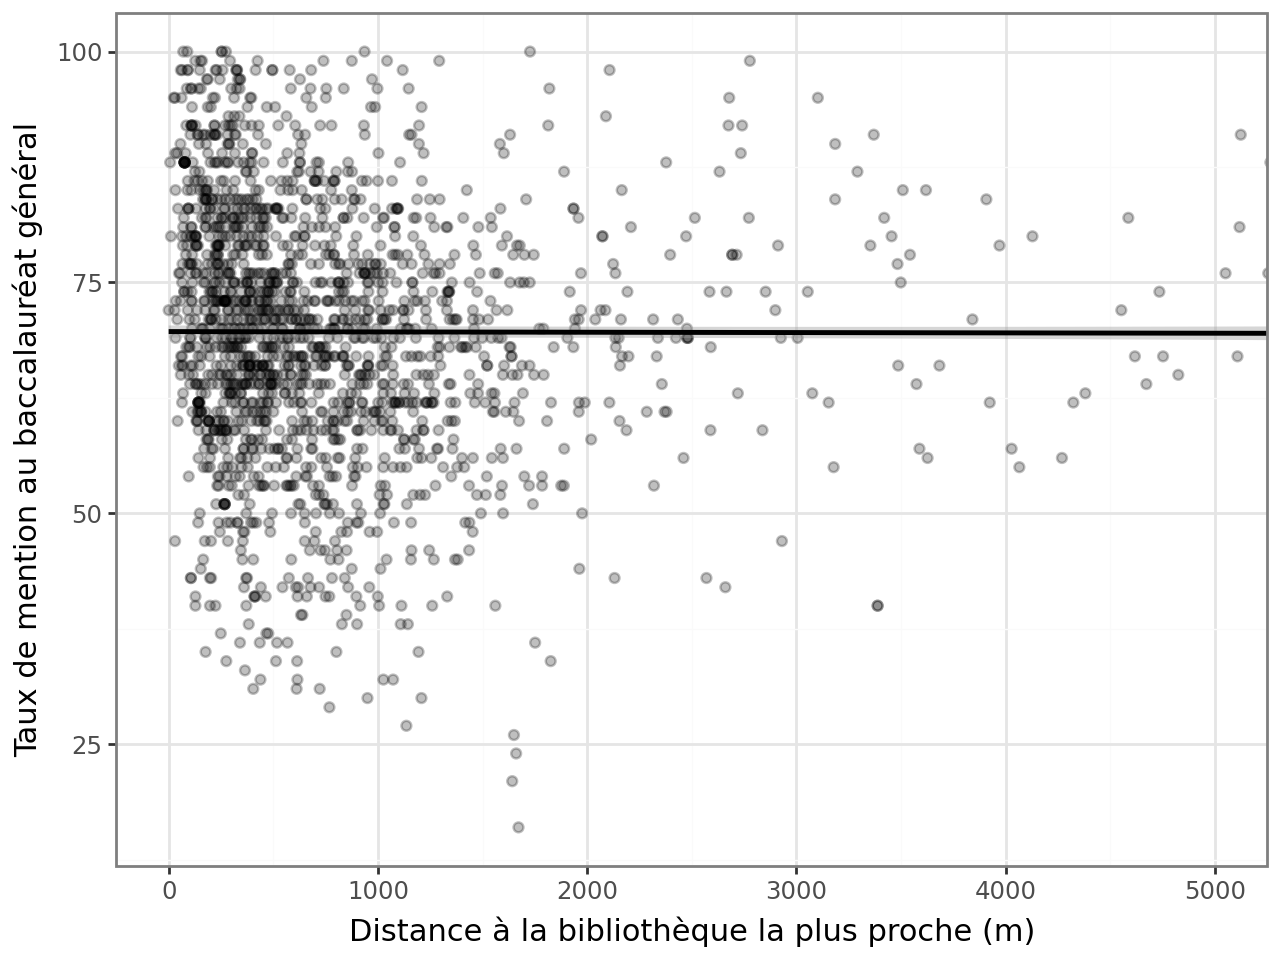

In [16]:
(
    ggplot(lycees_data) +
    aes(x="dist_proche_biblio_m", y="taux_men_gnle") +
    geom_point(alpha=0.25) +
    geom_smooth(method="lm") +
    coord_cartesian(xlim=[0, 5000]) +
    labs(
        x="Distance à la bibliothèque la plus proche (m)",
        y="Taux de mention au baccalauréat général"
    ) +
    theme_bw()
)

#### Interpretation :
Le graphique met en évidence une relation négative entre la distance à la bibliothèque la plus proche et le taux de mention : plus un lycée est éloigné d’un équipement culturel, plus sa performance tend à diminuer.

Bien que la dispersion soit importante, cette tendance justifie l’intégration de la distance comme variable explicative continue dans les modèles de régression.Interprétation

# Modélisation du Taux de Mention

## Introduction

Cette section a pour objectif d’identifier et de quantifier les déterminants du taux de mention au baccalauréat. La modélisation de cette variable repose sur les caractéristiques internes des lycées et celles de leur environnement externe, avec un focus spécifique sur l’accès aux bibliothèques. Le taux de mention est retenu plutôt que le taux de réussite en raison de sa variabilité plus importante, laquelle semble révéler une sensibilité accrue à des facteurs différenciants tels que l’environnement culturel ou la disponibilité de ressources spatiales.

## Cadre méthodologique

La méthode employée est la régression linéaire multiple, retenue pour sa capacité à produire des modèles interprétables, à quantifier l’ampleur des effets marginaux et à en tester la significativité statistique.

Les variables explicatives sont organisées en deux catégories :
- **Caractéristiques internes** : Indice de Position Sociale (IPS), statut (public ou privé) et taux de réussite.
- **Caractéristiques externes** : Nombre de bibliothèques situées à différentes distances du lycée, mesuré selon des échelles spatiales progressives.

## Démarche analytique

La modélisation suit une séquence méthodologique rigoureuse en cinq étapes afin d’assurer la robustesse des résultats :

1. **Analyse exploratoire** : Examen visuel des relations préliminaires entre les variables.
2. **Diagnostic de multicolinéarité** : Calcul des Facteurs d’Inflation de la Variance (VIF) pour détecter d’éventuelles redondances entre variables explicatives.
3. **Stratégie adaptative** :
   - En cas de multicolinéarité faible : régression incluant l’ensemble des variables pertinentes.
   - En cas de multicolinéarité problématique : sélection *stepwise* des variables visant à minimiser le Critère d’Information d’Akaike (AIC).

## Plan de modélisation

Cinq modèles successifs sont estimés pour évaluer l’influence des bibliothèques selon des **logiques d’usage spatialement différenciées**, allant de l’accessibilité immédiate à l’inscription dans un contexte territorial élargi :

1. **Modèle 1 : Accès immédiat et usage opportuniste**
   *Rayon de 500 mètres* : Mesure l’effet de la présence de bibliothèques accessibles en quelques minutes à pied, adaptées à des usages spontanés (intercours, attentes, fin de journée).

2. **Modèle 2 : Accès de proximité planifié et faible coût de déplacement**
   *Rayon de 1 kilomètre* : Intègre les bibliothèques accessibles en 10 à 15 minutes de marche, souvent situées sur le trajet domicile-lycée ou dans le quartier, correspondant à un usage intentionnel mais peu contraignant.

3. **Modèle 3 : Usage régulier structuré et mobilité intermédiaire**
   *Rayon de 2 kilomètres* : Capture les bibliothèques accessibles à vélo ou par un court trajet en transport en commun, associées à des pratiques d’étude planifiées et intégrées dans des routines hebdomadaires.

4. **Modèle 4 : Effet de contexte territorial et accessibilité via transports collectifs**
   *Rayon de 5 kilomètres* : Évalue la densité de l’offre culturelle dans un bassin de vie élargi, où la présence de bibliothèques reflète moins un usage individuel qu’un environnement territorial favorable à la réussite scolaire.

5. **Modèle 5 : Segmentation fine par tranches de distance disjointes**
   *Tranches non cumulatives (0–500 m, 500–1 000 m, 1 000–2 000 m, 2 000–5 000 m)* : Désagrège l’espace en couronnes concentriques mutuellement exclusives afin d’isoler l’effet propre à chaque échelle de distance et à la logique d’usage qui lui est associée.

## Outil d’analyse

Pour garantir la reproductibilité et la rigueur de cette démarche, une classe Python (`PipelineRegression`) a été développée. Cet outil intègre l’ensemble des méthodes nécessaires – diagnostics préliminaires, gestion de la multicolinéarité, estimation des modèles et sélection *stepwise* – permettant de mener l’analyse de manière systématique, cohérente et traçable.

## Initialisation de l'environnement d'analyse

Cette initialisation vise à établir un cadre stable pour modéliser le taux de mention au baccalauréat. Son objectif est d'isoler l’effet des facteurs environnementaux après avoir contrôlé les caractéristiques internes propres aux lycées.

Trois éléments sont définis de manière fixe pour l'ensemble de la démarche :

1.  **Jeu de données** : Un ensemble nettoyé et figé, utilisé systématiquement sous forme de copie pour préserver l'intégrité des données sources.
2.  **Variables de contrôle internes** :
    *   Indice de Position Sociale (IPS),
    *   Statut de l'établissement (public ou privé),
    *   Taux de réussite au baccalauréat.
3.  **Variable cible** : Le taux de mention, sélectionné pour sa variance plus importante et sa sensibilité présumée aux ressources externes.

Un **modèle de base**, expliquant la performance par les seuls déterminants internes, est d'abord estimé pour servir de référence. Ce modèle est ensuite **enrichi de manière itérative** par l'introduction de variables externes décrivant la présence de bibliothèques à différentes distances (par exemple, le nombre dans un rayon de 500 m, 1 km, etc.).

Cette procédure permet d'évaluer la contribution explicative supplémentaire de ces variables, **au-delà de l'effet déjà capté par les facteurs scolaires et sociaux contrôlés**. L'intégralité de cette démarche est automatisée via la classe `PipelineRegression`.

In [17]:
model = PipelineRegression()
data = lycees_data.copy()
vars_internes = ["ips_voie_gt", "statut_public_prive","taux_reu_gnle"]
target = "taux_men_gnle"
print(PipelineRegression.__doc__)


Pipeline de modélisation de régression linéaire.

Cette classe implémente une approche structurée et reproductible pour la
modélisation statistique, inspirée des bonnes pratiques en science des données.

Attributs
---------
X : array-like
    Variables explicatives standardisées
y : array-like
    Variable cible
model : statsmodels.regression.linear_model.RegressionResultsWrapper
    Modèle statistique ajusté
scaler : StandardScaler
    Standardiseur pour les variables explicatives
standardisation : bool
    Indicateur de standardisation des données
stepwise_best : statsmodels.regression.linear_model.RegressionResultsWrapper
    Meilleur modèle de la sélection stepwise
    
Références (Travaux de Lino Galiana)
------------------------------------
- https://pythonds.linogaliana.fr
- https://doi.org/10.5281/zenodo.8229676



### 1. Accès immédiat et usage opportuniste des bibliothèques  
Rayon : 0–500 mètres

Ce modèle évalue l’effet de la proximité immédiate des bibliothèques, définie comme une distance inférieure à 500 mètres du lycée. Cette échelle correspond à une accessibilité spontanée, compatible avec un déplacement à pied en moins de cinq minutes et ne nécessitant ni planification ni coût cognitif ou temporel significatif. Il vise à capter un usage opportuniste de la ressource culturelle, typique d’élèves soumis à des contraintes temporelles strictes, telles qu’un emploi du temps scolaire chargé ou l’absence de temps libre structuré.

Ce type d’usage se manifeste par une fréquentation ponctuelle, souvent limitée aux récréations, aux intercours ou aux périodes d’attente, et repose sur une décision quasi instantanée motivée par la disponibilité immédiate du lieu. Il implique une faible dépendance à l’organisation familiale, aux ressources de mobilité ou à l’autonomie personnelle de l’élève. Ce comportement s’inscrit dans une logique de rationalité limitée : l’élève ne cherche pas le lieu d’étude optimal, mais simplement le plus accessible au moment où le besoin se fait sentir.

Ce modèle constitue ainsi une base de référence comportementale minimale, reflétant l’effet direct et immédiat de l’environnement spatial sur les pratiques scolaires.

In [18]:
features_1 = vars_internes+["nb_biblio_500"]

/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:286: UserWarning: Les variables suivantes ne sont pas numériques et seront exclues: ['statut_public_prive']


<Figure size 1200x1000 with 0 Axes>

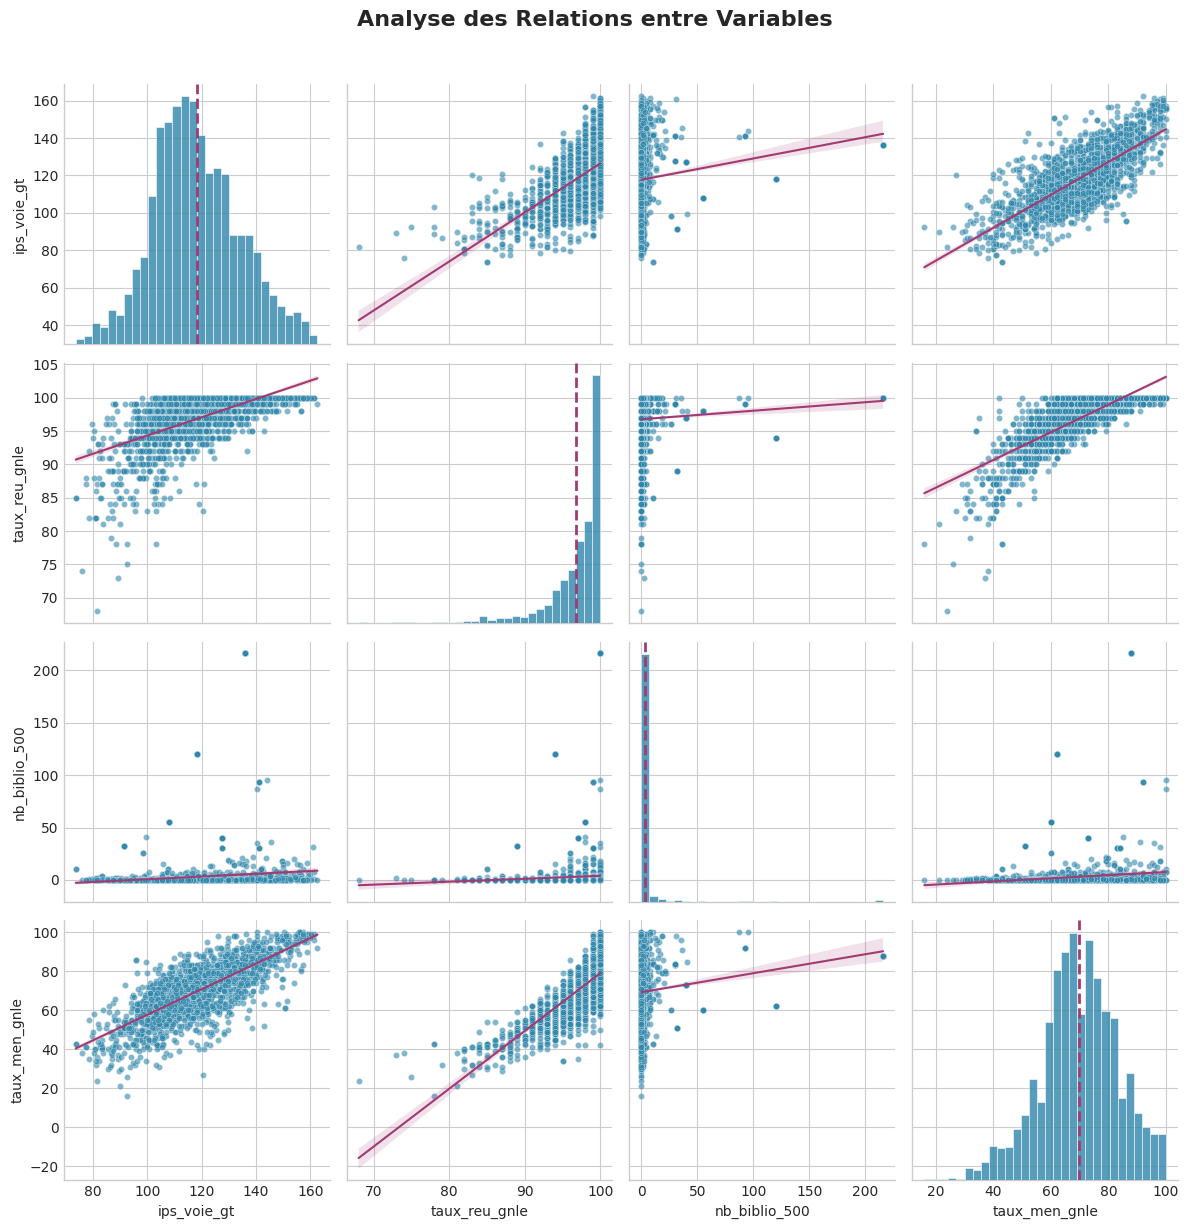

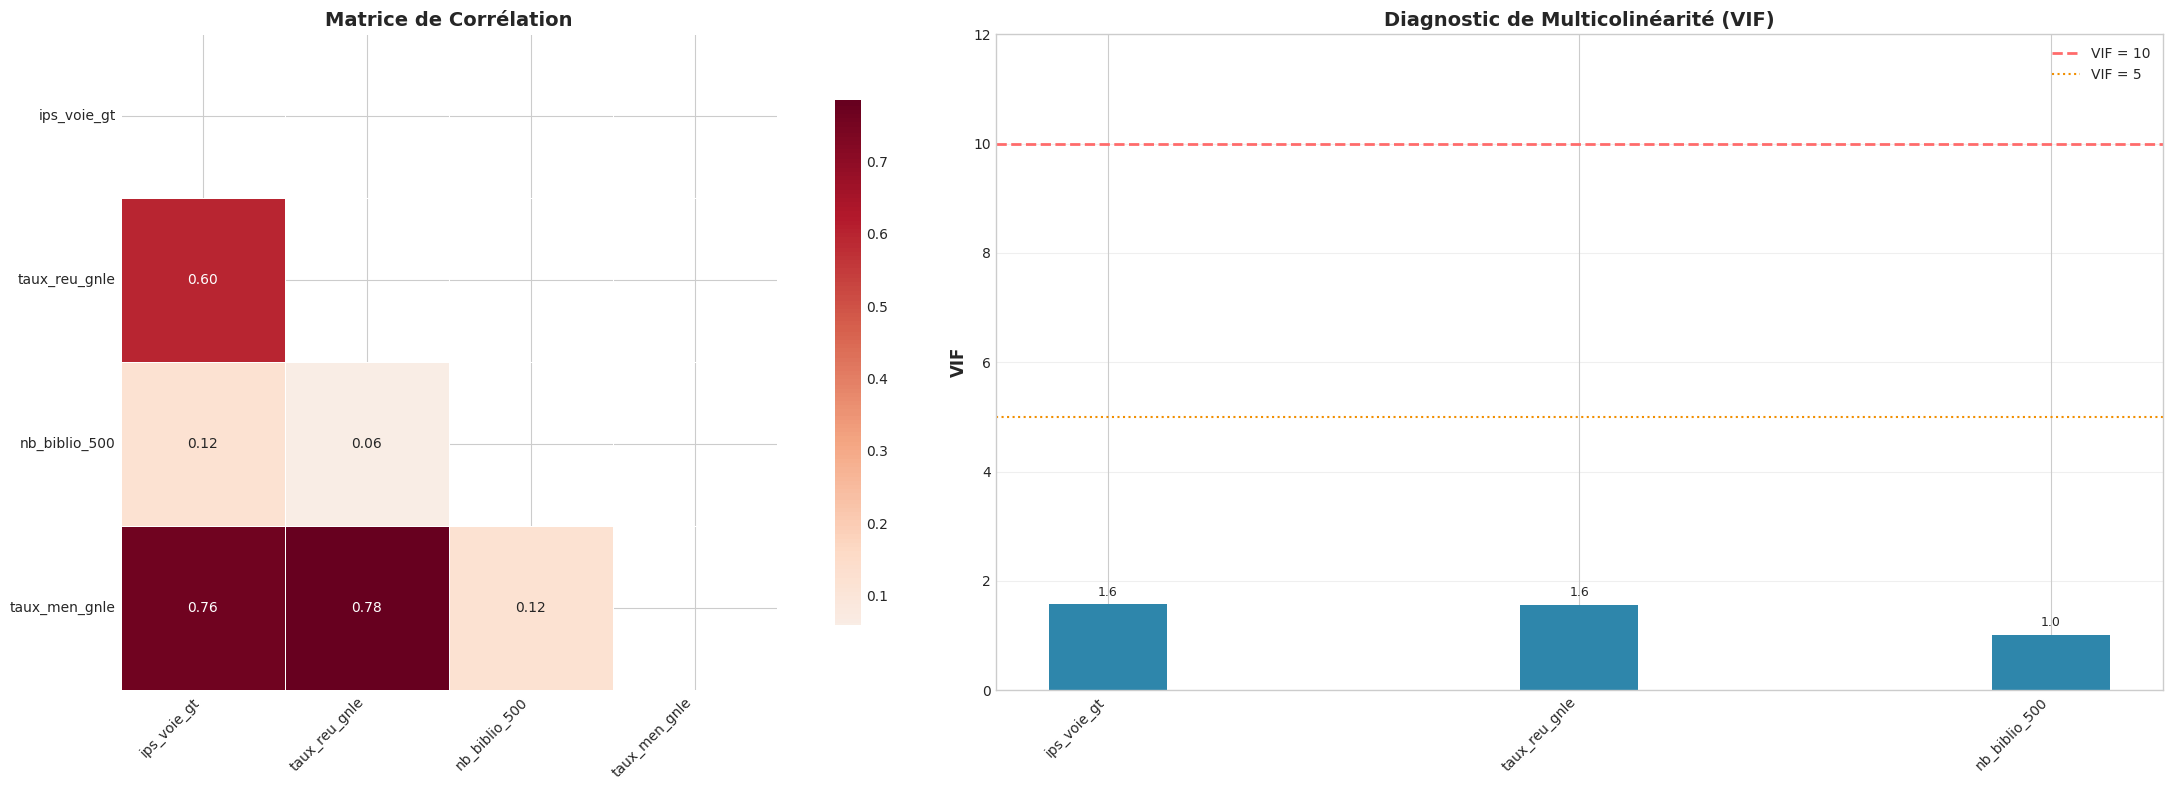

In [19]:
paires = model.paires_plot(data=data , features=features_1 , target=target)
headmap_vif = model.headmap_vif(data = data , features = features_1 , target = target)
plt.show()

**Interprétation**

 Le pair plot révèle des relations linéaires positives entre les variables explicatives et la variable cible. La distribution de l’Indice de Position Sociale (IPS) est centrée autour de 120, avec une dispersion modérée. Le taux de réussite présente une asymétrie légère vers les valeurs élevées, reflétant la concentration des lycées dans une fourchette de performance élevée. Le nombre de bibliothèques à 500 mètres est fortement concentré sur des valeurs faibles, avec une majorité de lycées n’ayant aucune ou très peu de bibliothèques à cette distance. La relation entre le taux de mention et les autres variables est nettement positive : plus l’IPS ou le taux de réussite augmente, plus le taux de mention s’élève. L’effet des bibliothèques à 500 mètres est visible mais modeste, avec une pente ascendante légère.

La matrice de corrélation confirme ces observations. Le taux de mention est fortement corrélé à l’IPS (+0,76) et au taux de réussite (+0,78), ce qui souligne leur rôle dominant. La corrélation entre le nombre de bibliothèques à 500 mètres et le taux de mention est faible (+0,12), cohérente avec un effet marginal. Aucune corrélation forte n’est observée entre les variables explicatives, indiquant une absence de redondance.

Le diagnostic VIF montre que tous les facteurs d’inflation de la variance sont inférieurs à 2, ce qui signifie qu’il n’y a pas de multicolinéarité problématique. Les coefficients estimés sont donc stables et fiables, et les erreurs standard robustes utilisées dans la régression ne sont pas nécessaires pour corriger un biais lié à la colinéarité.

In [20]:

model.fit(data=data , features=features_1 , target=target , include_robust=True , standardisation=True)

                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     1042.
Date:                Sun, 14 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:10:24   Log-Likelihood:                -6612.9
No. Observations:                1981   AIC:                         1.324e+04
Df Residuals:                    1976   BIC:                         1.326e+04
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

**Interprétation** : Le Modèle 1 explique 75 % de la variance du taux de mention (R² ajusté = 0,750), avec tous les coefficients significatifs au seuil de 1 %. Le taux de mention moyen prédit pour un lycée « moyen » — c’est-à-dire avec des valeurs moyennes d’IPS, de taux de réussite, de statut privé et de proximité aux bibliothèques — s’élève à 71,1 %.

Par rapport aux lycées privés, les lycées publics affichent un taux de mention inférieur de 2,18 points, toutes choses égales par ailleurs. Une augmentation d’un écart-type de l’Indice de Position Sociale (IPS) est associée à une hausse de 5,59 points du taux de mention, ce qui souligne le poids déterminant de l’origine sociale. De même, une augmentation d’un écart-type du taux de réussite au baccalauréat se traduit par une augmentation de 6,91 points du taux de mention, confirmant que la performance collective du lycée reste le facteur le plus puissant.

Enfin, une hausse d’un écart-type du nombre de bibliothèques situées à moins de 500 mètres du lycée est associée à une augmentation de 0,46 point du taux de mention. Cet effet, bien que modeste en amplitude, est positif et statistiquement significatif, ce qui soutient l’hypothèse d’un usage opportuniste de ces équipements par les élèves.

Toutes les variables explicatives étant normalisées, les coefficients expriment l’impact d’une variation d’un écart-type de la variable sur le taux de mention, mesuré en points de pourcentage.

## 2. Accès de proximité planifié et préférence pour un faible coût de déplacement  
Rayon : 0–1 000 mètres

Ce modèle élargit l’analyse à un rayon d’un kilomètre, incluant non seulement les usagers opportunistes du modèle précédent, mais aussi des élèves capables d’investir un effort minimal — typiquement une marche de 10 à 15 minutes — pour accéder à une bibliothèque. À cette échelle, l’usage devient intentionnel et planifié, reflétant une préférence marquée pour les conditions de travail offertes par la bibliothèque, telles que le calme, l’accès aux ressources documentaires et l’absence de distractions.

Ce comportement suppose une motivation scolaire plus affirmée, une capacité à intégrer la bibliothèque dans une routine quotidienne ou hebdomadaire, ainsi qu’une interdépendance entre le lieu d’enseignement et le lieu de vie : la bibliothèque peut ainsi se situer sur le trajet domicile–lycée ou à proximité du quartier résidentiel, ce qui réduit le coût effectif du déplacement.  

Le modèle permet de tester si l’effet observé à très courte distance s’amplifie lorsque l’on inclut des élèves dont l’engagement scolaire repose sur une organisation autonome, tout en restant compatible avec une mobilité exclusivement pédestre. Il introduit ainsi une dimension de choix actif, où l’environnement spatial n’est plus seulement une contrainte ou une opportunité passive, mais interagit directement avec les pratiques individuelles d’auto-régulation et de planification scolaire.

In [21]:

features_2 = vars_internes+["nb_biblio_1000"]

/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:286: UserWarning: Les variables suivantes ne sont pas numériques et seront exclues: ['statut_public_prive']


<Figure size 1200x1000 with 0 Axes>

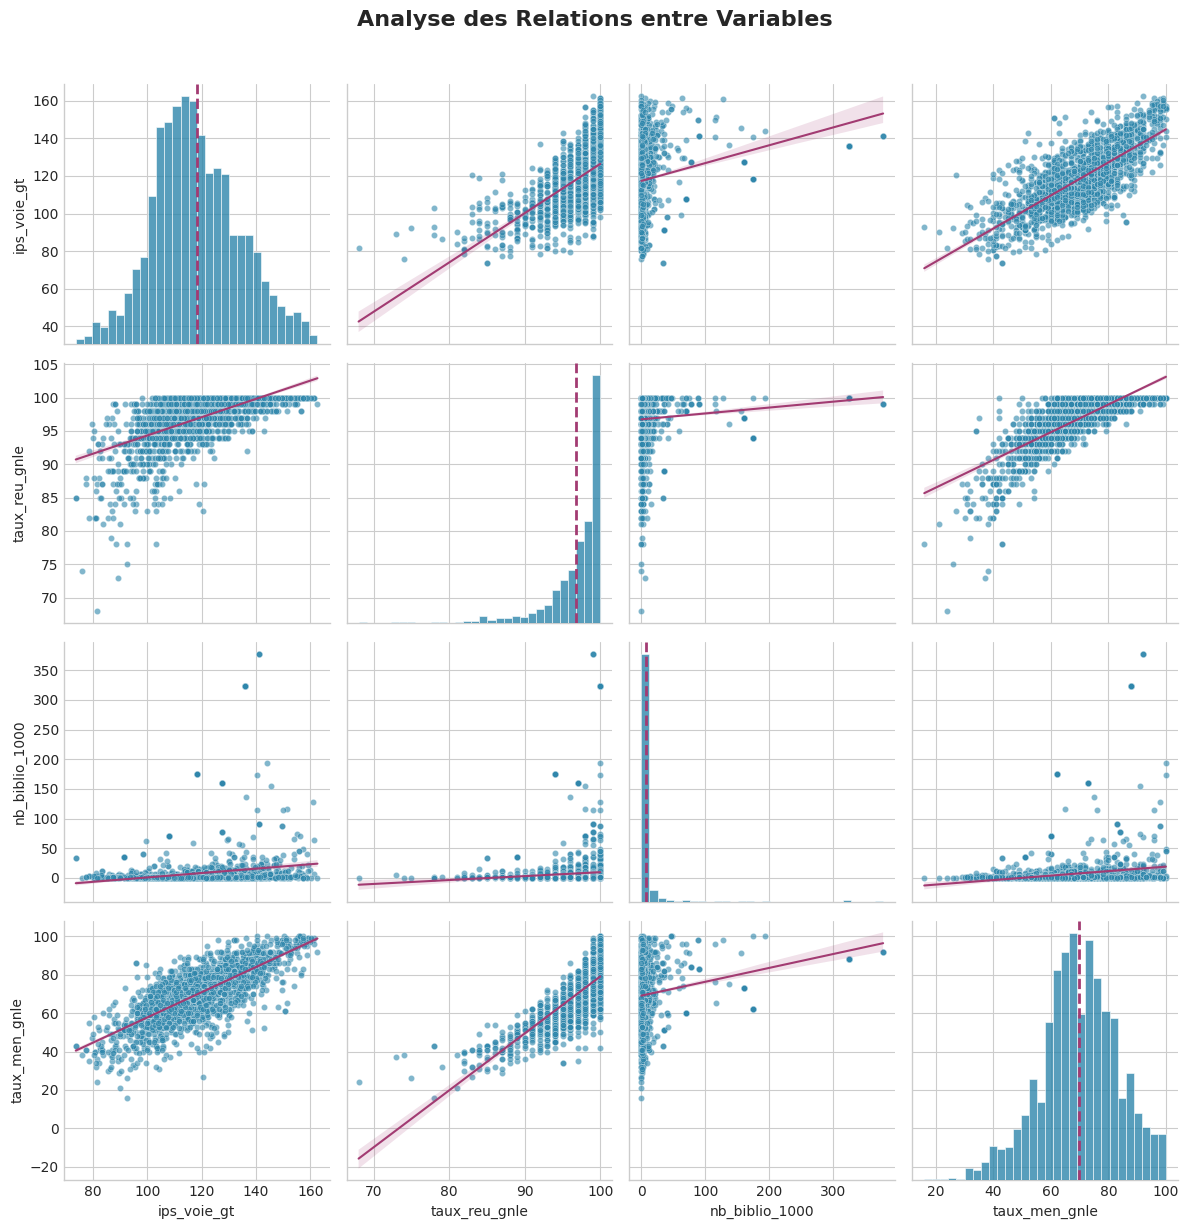

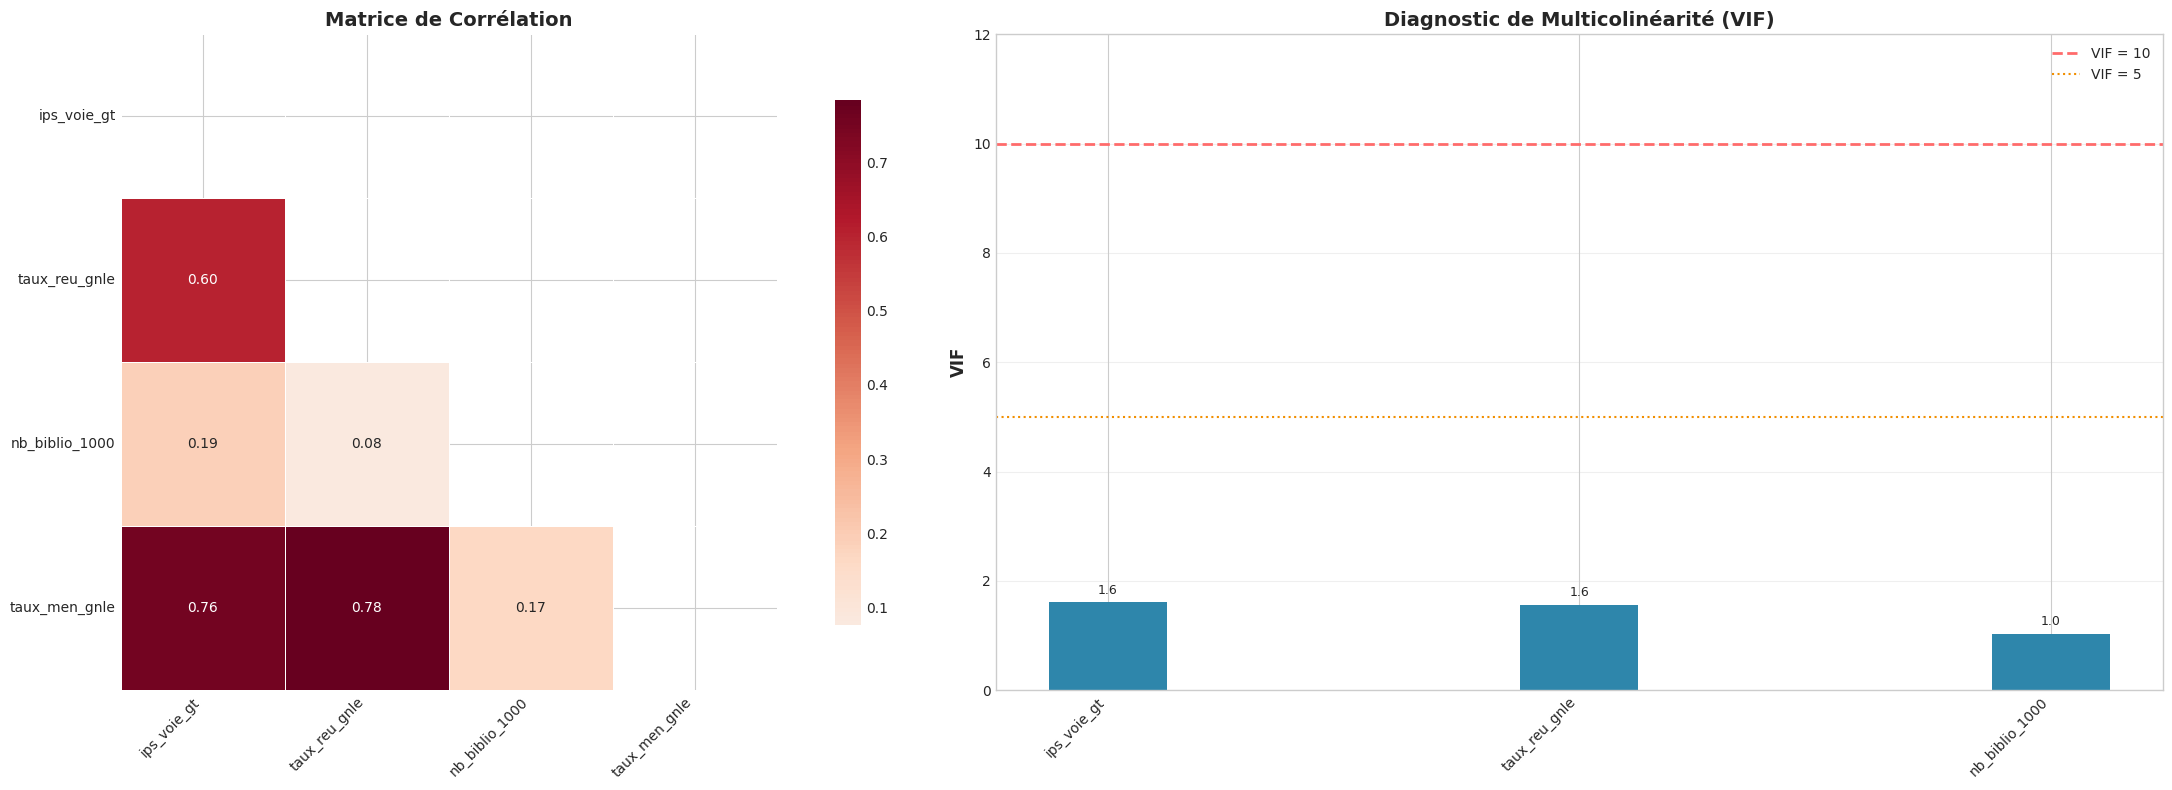

In [22]:
paires = model.paires_plot(data=data , features=features_2 , target=target)
headmap_vif = model.headmap_vif(data = data , features = features_2 , target = target)
plt.show()

**Interprétation**

Le pair plot montre que la relation entre le taux de mention et les variables explicatives reste fortement positive. La distribution de l’Indice de Position Sociale (IPS) est similaire à celle du Modèle 1, centrée autour de 120. Le taux de réussite présente une concentration dans les valeurs élevées, cohérente avec la performance scolaire moyenne des lycées. Le nombre de bibliothèques à 1 kilomètre est plus élevé qu’à 500 mètres, avec une dispersion plus large — ce qui suggère que cette échelle couvre davantage de contextes urbains variés. La pente de régression entre le nombre de bibliothèques à 1 km et le taux de mention est légèrement plus prononcée qu’en Modèle 1, indiquant un effet marginal plus marqué.

La matrice de corrélation confirme que le taux de mention est fortement lié à l’IPS (+0,76) et au taux de réussite (+0,78), comme précédemment. La corrélation avec le nombre de bibliothèques à 1 km est faible mais notable (+0,17), supérieure à celle observée à 500 mètres (+0,12). Aucune corrélation significative n’est détectée entre les variables explicatives, ce qui garantit l’absence de redondance et la stabilité des estimations.

Le diagnostic VIF montre que tous les facteurs d’inflation de la variance sont inférieurs à 2, confirmant l’absence de multicolinéarité problématique. Les coefficients estimés sont donc fiables, et les erreurs standard robustes utilisées dans la régression ne sont pas nécessaires pour corriger un biais lié à la colinéarité.

In [23]:

model.fit(data=data , features=features_2 , target=target, include_robust=True , standardisation=True)

                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     1042.
Date:                Sun, 14 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:10:28   Log-Likelihood:                -6609.8
No. Observations:                1981   AIC:                         1.323e+04
Df Residuals:                    1976   BIC:                         1.326e+04
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

**Interprétation** : Le Modèle 2 explique 75,1 % de la variance du taux de mention (R² ajusté = 0,751), avec tous les coefficients significatifs au seuil de 1 %. Le taux de mention moyen prédit pour un lycée « moyen » — c’est-à-dire avec des valeurs moyennes d’IPS, de taux de réussite, de statut privé et de nombre de bibliothèques à 1 km — est de 71,2 %.

Les lycées publics affichent un taux de mention inférieur de 2,26 points à celui des lycées privés, un écart légèrement plus marqué qu’en Modèle 1. L’effet de l’Indice de Position Sociale (IPS) reste très robuste : une augmentation d’un écart-type de l’IPS est associée à une hausse de 5,50 points du taux de mention, bien que cet effet soit légèrement atténué par rapport au Modèle 1. Le taux de réussite conserve son rôle de déterminant dominant, avec un effet de +6,93 points pour une augmentation d’un écart-type, stable par rapport au Modèle 1.

Concernant les bibliothèques, une augmentation d’un écart-type du nombre de bibliothèques situées à moins de 1 km du lycée est associée à une hausse de 0,61 point du taux de mention. Cet effet est nettement plus fort que celui observé à 500 mètres (+0,46), ce qui confirme l’hypothèse d’un usage planifié et intentionnel à cette échelle : les élèves peuvent intégrer la bibliothèque à leur trajet domicile–lycée ou à une routine hebdomadaire avec un coût de déplacement faible mais non négligeable.

Toutes les variables explicatives étant normalisées, les coefficients expriment l’impact d’une variation d’un écart-type de la variable sur le taux de mention, mesuré en points de pourcentage.

## 3. Usage régulier structuré et tolérance à un coût de mobilité intermédiaire  
Rayon : 0–2 000 mètres

Le troisième modèle étend l’analyse à un rayon de 2 kilomètres, correspondant à une mobilité active ou légèrement motorisée — vélo, trottinette ou un à deux arrêts de transport en commun. Cette distance suppose un investissement plus substantiel en temps et en planification, et reflète un engagement scolaire durable.

À cette échelle, la fréquentation de la bibliothèque ne relève plus d’une simple adaptation ponctuelle aux contraintes immédiates, mais s’inscrit dans des pratiques régulières et intentionnelles. Celles-ci incluent des séances de travail dédiées en dehors des heures de cours, une utilisation intensive — tant en durée qu’en fréquence — des ressources documentaires, ainsi qu’une intégration dans les routines hebdomadaires, souvent en lien avec des objectifs académiques précis tels que la préparation au baccalauréat ou la rédaction de devoirs longs.

Ce modèle capte également un effet résidentiel indirect : une bibliothèque située à 1,8 km du lycée peut se trouver à seulement 300 mètres du domicile de nombreux élèves, ce qui augmente sensiblement sa fréquentation réelle. Il permet ainsi d’évaluer non seulement l’accessibilité depuis l’établissement scolaire, mais aussi l’offre culturelle du bassin de vie dans lequel le lycée est inséré, en croisant mobilité scolaire et résidentielle.


In [24]:
features_3 = vars_internes+["nb_biblio_2000"]

/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:286: UserWarning: Les variables suivantes ne sont pas numériques et seront exclues: ['statut_public_prive']


<Figure size 1200x1000 with 0 Axes>

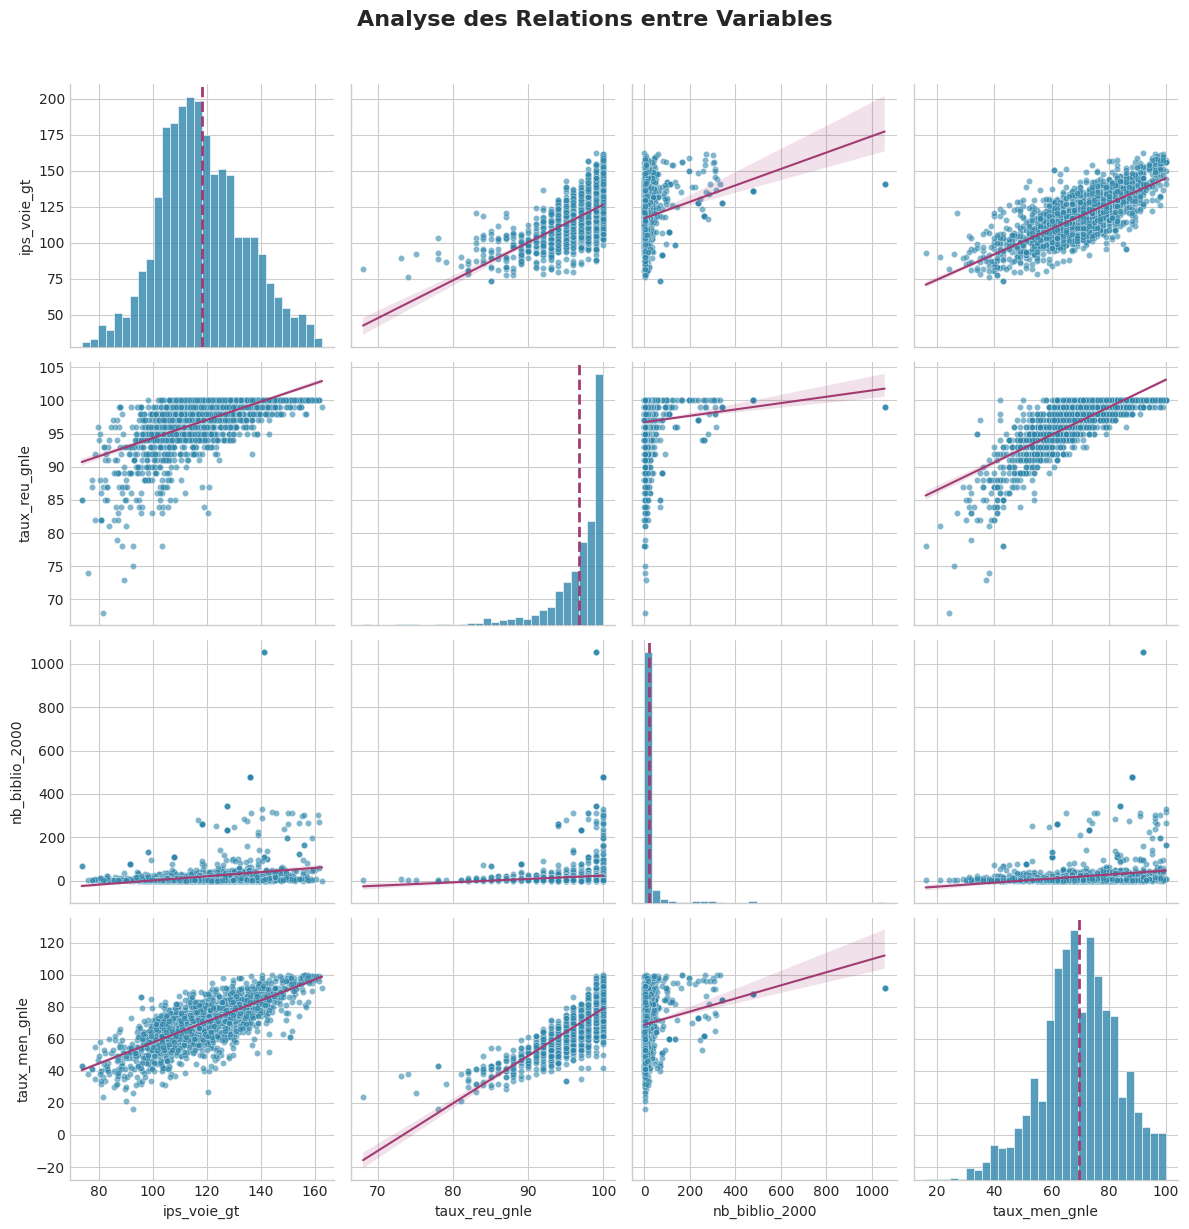

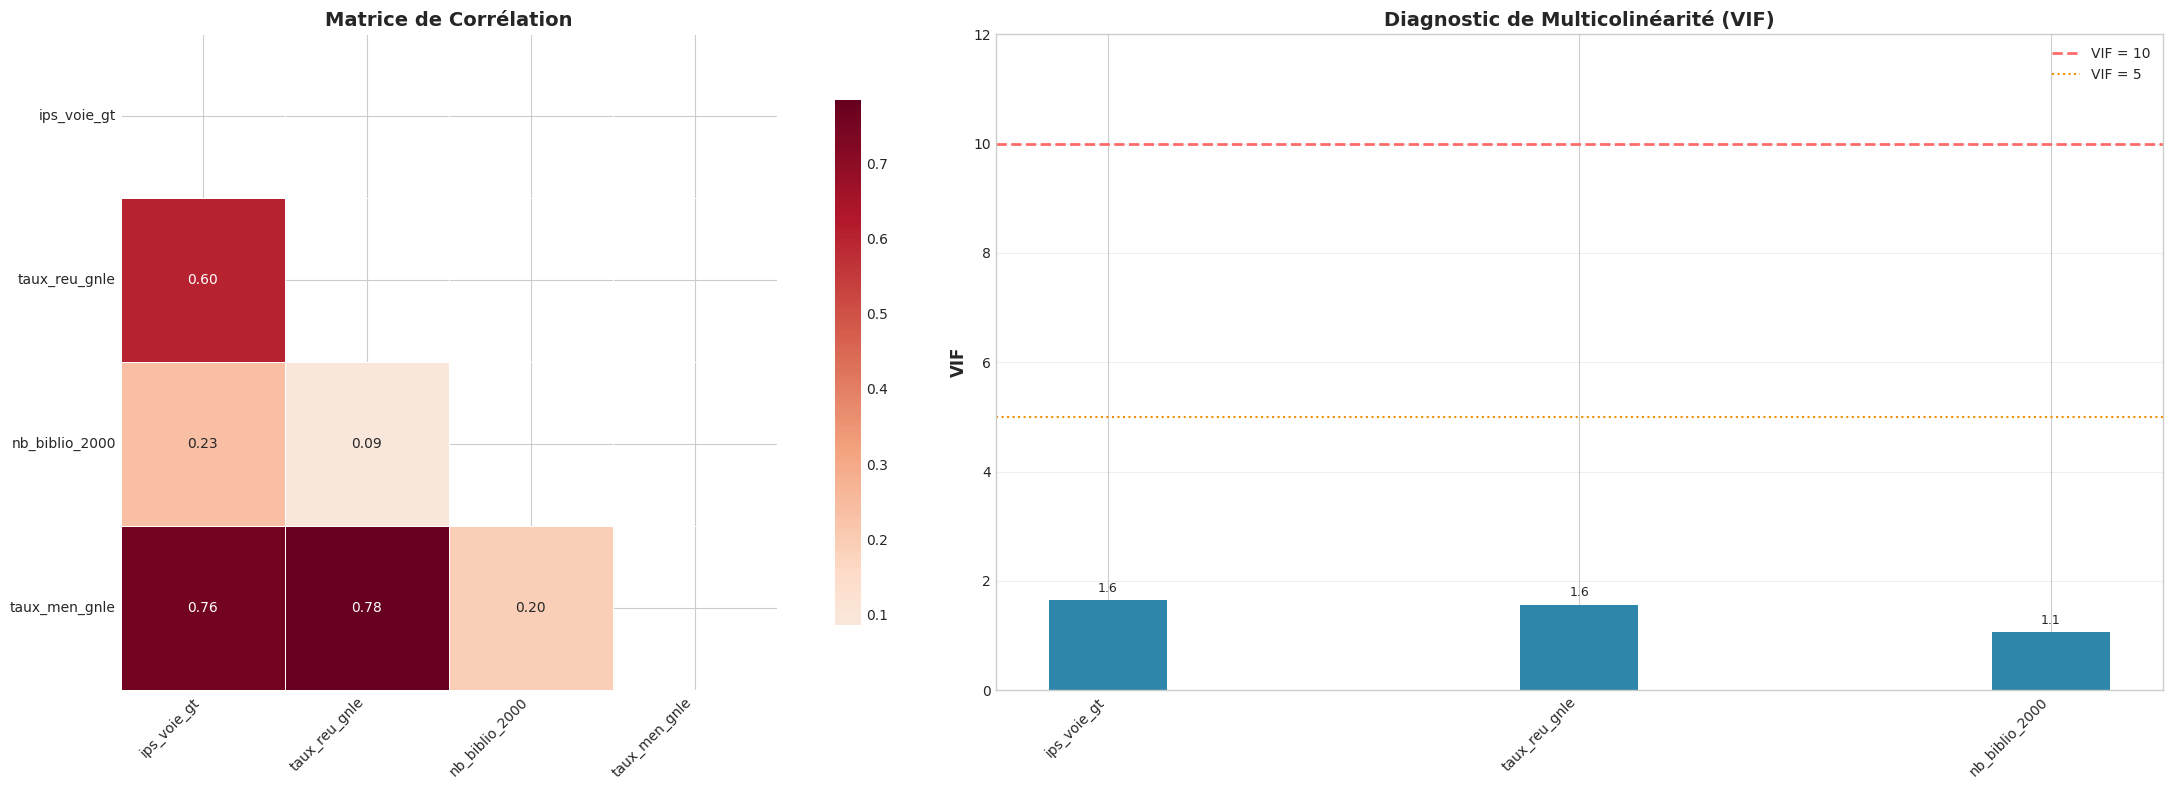

In [25]:
paires = model.paires_plot(data=data , features=features_3 , target=target)
headmap_vif  = model.headmap_vif(data = data , features = features_3 , target = target)
plt.show()

**Interprétation**

Le pair plot révèle que la distribution de l’Indice de Position Sociale (IPS) reste centrée autour de 120, avec une dispersion légèrement accrue par rapport aux modèles précédents. Le taux de réussite présente une structure similaire, concentré dans les valeurs élevées. Le nombre de bibliothèques à 2 kilomètres est nettement plus élevé qu’à 500 m ou 1 km, avec une dispersion importante — ce qui reflète une plus grande diversité d’environnements urbains et une densité d’équipements culturels plus variable. La pente de régression entre le nombre de bibliothèques à 2 km et le taux de mention est plus marquée qu’aux échelles inférieures, suggérant un effet marginal plus fort.

La matrice de corrélation confirme que le taux de mention est fortement lié à l’IPS (+0,76) et au taux de réussite (+0,78), comme dans les modèles antérieurs. La corrélation avec le nombre de bibliothèques à 2 km est faible mais significative (+0,20), supérieure à celle observée à 1 km (+0,17). Aucune corrélation forte n’est détectée entre les variables explicatives, ce qui garantit l’absence de redondance et la stabilité des estimations.

Le diagnostic VIF montre que tous les facteurs d’inflation de la variance sont inférieurs à 2, confirmant l’absence de multicolinéarité problématique. Les coefficients estimés sont donc fiables, et les erreurs standard robustes utilisées dans la régression ne sont pas nécessaires pour corriger un biais lié à la colinéarité.

In [26]:

model.fit(data=data , features=features_3 , target=target, include_robust=True , standardisation=True)

                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     1034.
Date:                Sun, 14 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:10:33   Log-Likelihood:                -6607.6
No. Observations:                1981   AIC:                         1.323e+04
Df Residuals:                    1976   BIC:                         1.325e+04
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

**Interprétation** : Le Modèle 3 explique 75,2 % de la variance du taux de mention (R² ajusté = 0,752), avec tous les coefficients significatifs au seuil de 1 %. Le taux de mention moyen prédit pour un lycée « moyen » — c’est-à-dire avec des valeurs moyennes d’IPS, de taux de réussite, de statut privé et de nombre de bibliothèques à 2 km — s’élève à 71,2 %.

L’écart entre lycées publics et privés s’accentue légèrement : les lycées publics affichent un taux de mention inférieur de 2,31 points. L’effet de l’Indice de Position Sociale (IPS) reste très marqué, avec une augmentation de 5,42 points du taux de mention pour une hausse d’un écart-type de l’IPS, bien que cet effet soit en légère baisse par rapport aux modèles précédents. Le taux de réussite conserve sa position de principal déterminant, avec un effet stable et élevé de +6,95 points.

Le coefficient associé au nombre de bibliothèques à moins de 2 km atteint +0,70 point, soit l’effet le plus fort parmi les trois premiers modèles. Cela confirme que cette échelle correspond à un usage régulier et structuré : les déplacements en vélo, en trottinette ou via un court trajet en transports en commun permettent aux élèves d’intégrer la bibliothèque à leurs routines d’étude, en particulier lorsqu’ils visent explicitement la mention. 

Toutes les variables explicatives étant normalisées, les coefficients expriment l’impact d’une variation d’un écart-type de la variable sur le taux de mention, mesuré en points de pourcentage.

## 4. Effet agrégé de contexte territorial et accessibilité via les transports collectifs  
Rayon : 0–5 000 mètres

Ce modèle considère un rayon étendu de 5 kilomètres, correspondant à une zone d’influence départementale ou intercommunale. À cette échelle, l’accès aux bibliothèques implique généralement l’usage des transports en commun, voire une organisation logistique — gestion des horaires, achat de titres de transport, correspondances — ce qui découple fortement la distance géographique de l’usage réel.

La densité de bibliothèques dans ce périmètre ne fonctionne plus ici comme un indicateur d’accessibilité individuelle, mais comme un proxy du capital culturel territorial. Elle reflète le niveau d’investissement public dans les équipements éducatifs et culturels, la présence d’institutions savantes telles que des universités ou des centres de recherche — susceptibles de générer une offre de bibliothèques spécialisées —, ainsi que des caractéristiques socio-économiques globales du territoire, notamment le revenu moyen, le niveau de qualification des ménages ou la densité étudiante.

L’effet observé ne mesure donc pas directement la fréquentation des bibliothèques par les élèves, mais un effet de contexte : les lycées situés dans des territoires « culturellement riches » tendent à afficher de meilleures performances scolaires, indépendamment de l’usage effectif des lieux par les élèves. Cet avantage peut s’expliquer par des normes sociales partagées valorisant la scolarité, une pression culturelle positive ou, plus généralement, un environnement favorable à la valorisation des études.

In [27]:
features_4 = vars_internes+["nb_biblio_5000"]

/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:286: UserWarning: Les variables suivantes ne sont pas numériques et seront exclues: ['statut_public_prive']


<Figure size 1200x1000 with 0 Axes>

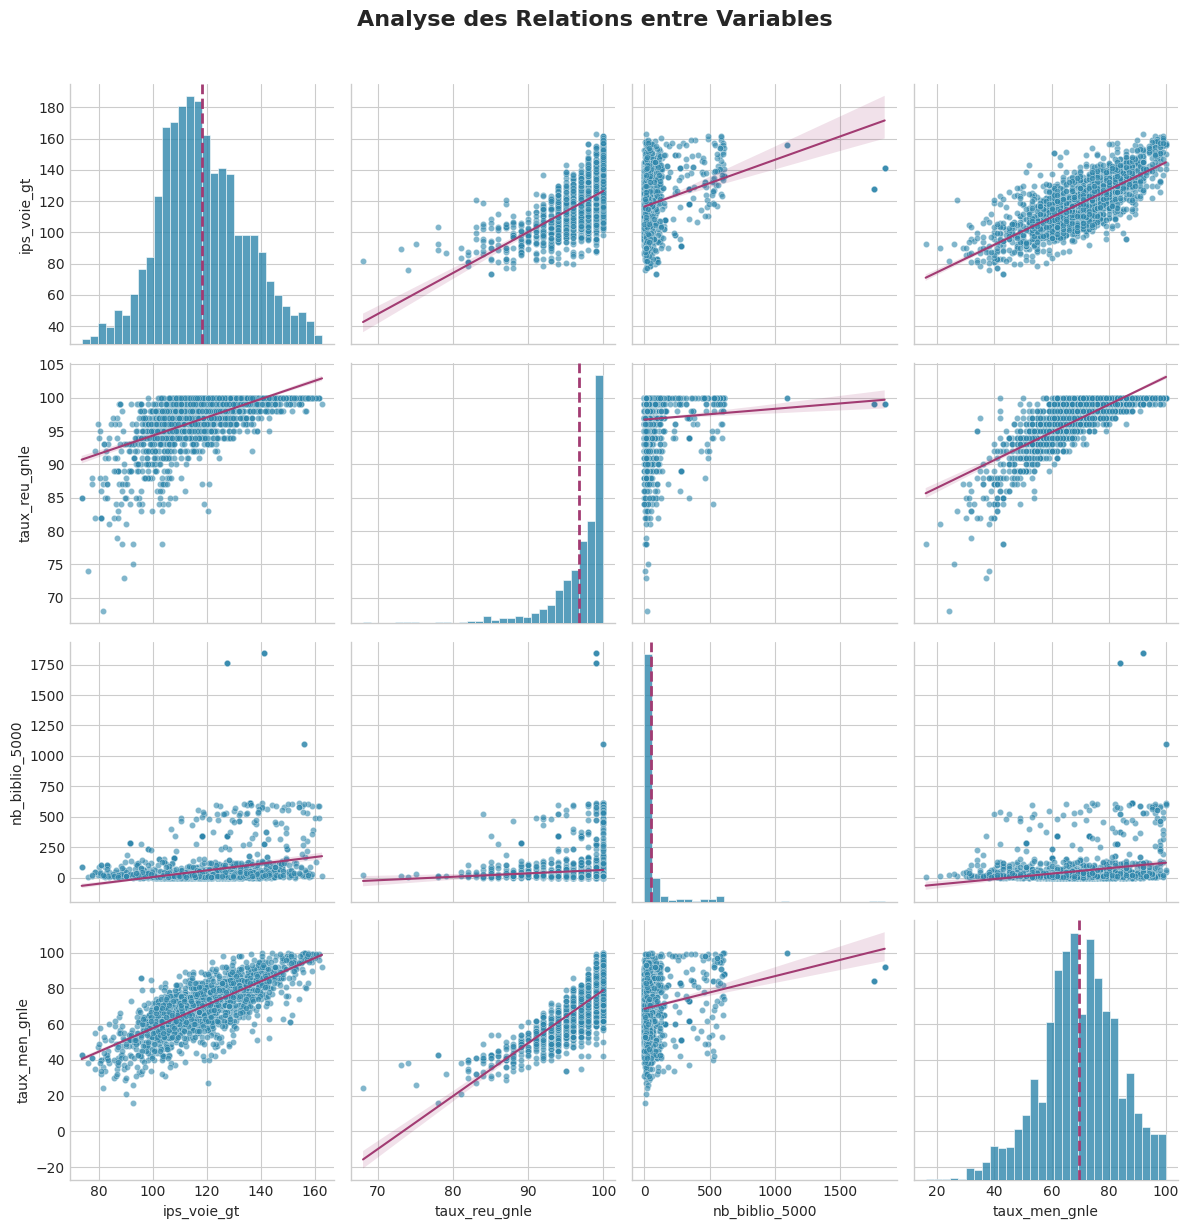

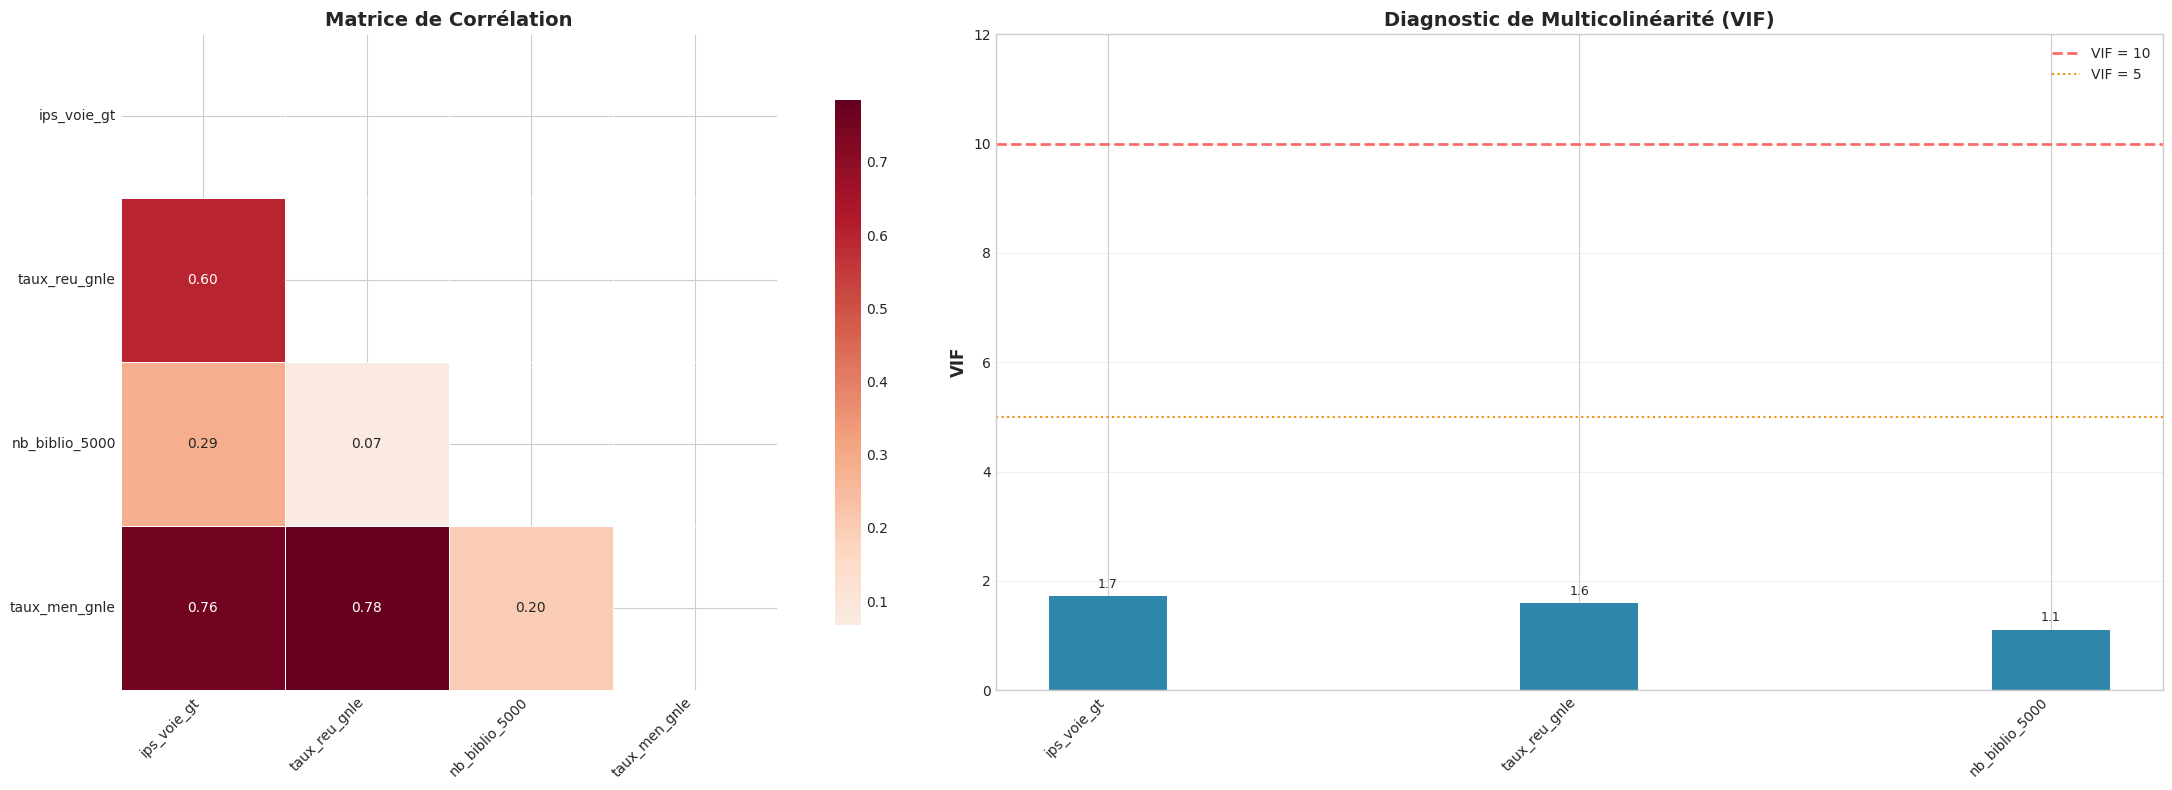

In [28]:
paires = model.paires_plot(data=data , features=features_4 , target=target)
headmap_vif = model.headmap_vif(data = data , features = features_4 , target = target)
plt.show()

**Interprétation**

Le pair plot montre que la distribution de l’Indice de Position Sociale (IPS) reste centrée autour de 120, avec une dispersion similaire aux modèles précédents. Le taux de réussite présente une structure stable, concentré dans les valeurs élevées. Le nombre de bibliothèques à 5 kilomètres est fortement dispersé, avec des valeurs allant jusqu’à plus de 1 500 — ce qui reflète la diversité des bassins de vie urbains ou intercommunaux. La pente de régression entre le nombre de bibliothèques à 5 km et le taux de mention est légèrement moins prononcée qu’à 2 km, suggérant un effet marginal atténué.

La matrice de corrélation confirme que le taux de mention est fortement lié à l’IPS (+0,76) et au taux de réussite (+0,78), comme dans les modèles antérieurs. La corrélation avec le nombre de bibliothèques à 5 km est faible mais positive (+0,20), identique à celle observée à 2 km, mais avec une dispersion plus importante. Aucune corrélation forte n’est détectée entre les variables explicatives, ce qui garantit l’absence de redondance et la stabilité des estimations.

Le diagnostic VIF montre que tous les facteurs d’inflation de la variance sont inférieurs à 2, confirmant l’absence de multicolinéarité problématique. Les coefficients estimés sont donc fiables, et les erreurs standard robustes utilisées dans la régression ne sont pas nécessaires pour corriger un biais lié à la colinéarité.

In [29]:

model.fit(data=data , features=features_4 , target=target, include_robust=True , standardisation=True)

                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     1028.
Date:                Sun, 14 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:10:38   Log-Likelihood:                -6609.5
No. Observations:                1981   AIC:                         1.323e+04
Df Residuals:                    1976   BIC:                         1.326e+04
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

**Interprétation** : Le Modèle 4 explique 75,1 % de la variance du taux de mention (R² ajusté = 0,751), avec tous les coefficients significatifs au seuil de 1 %. Le taux de mention moyen prédit pour un lycée « moyen » — c’est-à-dire avec des valeurs moyennes d’IPS, de taux de réussite, de statut privé et de nombre de bibliothèques à 5 km — est de 71,3 %.

L’écart entre lycées publics et privés persiste et s’accentue légèrement à –2,33 points. L’effet de l’Indice de Position Sociale (IPS) reste important, mais se réduit à +5,37 points, suggérant que, à cette échelle territoriale plus large, le poids de l’origine sociale individuelle est partiellement relayé par des facteurs contextuels. Le taux de réussite demeure le déterminant le plus puissant, avec un effet légèrement accru (+6,99 points).

Le coefficient associé au nombre de bibliothèques à moins de 5 km est de +0,64 point : l’effet est positif et significatif, mais inférieur à celui observé à 2 km (+0,70). Cette baisse confirme le passage d’un usage individuel à un effet de contexte : à cette distance, la présence de bibliothèques agit moins comme une ressource directement mobilisable par les élèves que comme un indicateur du capital culturel du territoire — reflétant notamment l’investissement public, la densité de diplômés ou la proximité d’institutions savantes.

Toutes les variables explicatives étant normalisées, les coefficients expriment l’impact d’une variation d’un écart-type de la variable sur le taux de mention, mesuré en points de pourcentage.



### **Conclusion : L’effet des bibliothèques n’est pas linéaire avec la distance**
L’analyse menée sur quatre échelles spatiales — 500 m, 1 km, 2 km et 5 km — confirme que l’impact des bibliothèques sur le taux de mention n’est pas constant, mais varie de manière non linéaire selon la distance. Cette variation reflète des logiques d’usage distinctes, correspondant à des profils d’élèves et à des formes d’engagement scolaire différenciés.

L’effet est modeste à très courte distance (+0,46 à 500 m), où l’usage est opportuniste et dépendant de contraintes temporelles strictes. Il se renforce à 1 km (+0,61), échelle compatible avec un déplacement planifié et un intégration au trajet domicile–lycée. Il atteint son maximum à 2 km (+0,70), distance à laquelle la fréquentation devient régulière et structurée, typique des élèves capables d’organiser leur temps d’étude et de mobiliser les ressources spatiales de manière active. À 5 km, l’effet diminue légèrement (+0,64), traduisant moins un usage individuel qu’un effet de contexte : la densité de bibliothèques agit alors comme un indicateur du capital culturel territorial, reflétant la qualité générale de l’environnement socio-éducatif.

Le pic observé à 2 km constitue le résultat central de cette analyse. Il correspond à la distance optimale où l’effort de déplacement reste raisonnable, mais où l’usage devient suffisamment intentionnel et régulier pour produire un impact scolaire mesurable. Ce résultat illustre que l’espace éducatif n’est pas neutre : il interagit avec les ressources sociales, les capacités d’agir et les stratégies scolaires des élèves. Il valide également l’idée que l’accès aux équipements culturels ne suffit pas — c’est la capacité à les mobiliser de manière active qui détermine leur effet sur la réussite.

## 5. Segmentation fine des échelles d’accessibilité par tranches de distance disjointes

Ce modèle final rompt avec la logique cumulative des modèles précédents pour adopter une approche segmentée. Au lieu de compter toutes les bibliothèques situées à l’intérieur d’un rayon donné, il désagrège l’espace en couronnes concentriques non superposées, permettant d’associer chaque tranche de distance à un type spécifique de relation entre l’élève, le lycée et la bibliothèque.

Quatre variables sont introduites. La première, `nb_biblio_0_500`, correspond au nombre de bibliothèques situées entre 0 et 500 mètres du lycée. Cette tranche capture une accessibilité immédiate, compatible avec des usages spontanés et non planifiés, intégrés dans les interstices du temps scolaire tels que les récréations, les attentes ou la fin de journée.  

La deuxième variable, `nb_biblio_500_1000`, mesure le nombre de bibliothèques situées entre 500 mètres et 1 kilomètre. Elle capte des usages intentionnels mais peu coûteux, souvent liés à une proximité résidentielle ou à un trajet domicile–lycée qui rend la bibliothèque facilement accessible sans détour significatif.  

La troisième, `nb_biblio_1000_2000`, couvre la distance comprise entre 1 et 2 kilomètres. À cette échelle, l’accès suppose un engagement actif : déplacement dédié à vélo, à trottinette ou via un court trajet en transport en commun. Cela reflète une intégration de la bibliothèque dans des routines d’étude régulières, souvent organisées en dehors des heures de cours.  

Enfin, la quatrième variable, `nb_biblio_2000_5000`, comptabilise les bibliothèques situées entre 2 et 5 kilomètres. Ce rayon correspond à une accessibilité conditionnée par les transports collectifs ou par une organisation familiale. Il ne reflète plus un usage quotidien, mais plutôt l’inscription du lycée dans un bassin culturel plus large, où la présence de bibliothèques agit comme un signal d’un environnement globalement favorable à la valorisation scolaire.

Contrairement aux modèles précédents, où chaque rayon incluait les distances plus courtes, cette segmentation évite tout emboîtement spatial. Elle permet ainsi d’associer chaque tranche à une logique d’usage distincte et d’offrir une représentation plus fidèle de la diversité des pratiques réelles des élèves face à l’offre de bibliothèques, en tenant compte à la fois de leurs contraintes temporelles, de leurs ressources de mobilité et de leur degré d’engagement scolaire.

In [30]:
data["nb_biblio_0_500"] = data["nb_biblio_500"]
data["nb_biblio_500_1000"] = data["nb_biblio_1000"] - data["nb_biblio_500"]
data["nb_biblio_1000_2000"] = data["nb_biblio_2000"] - data["nb_biblio_1000"]
data["nb_biblio_2000_5000"] = data["nb_biblio_5000"] - data["nb_biblio_2000"]

In [31]:

features_5 = vars_internes + ["nb_biblio_0_500", "nb_biblio_500_1000", "nb_biblio_1000_2000", "nb_biblio_2000_5000"]

/home/onyxia/work/ensae-pythonds/src/classe_modelisation.py:286: UserWarning: Les variables suivantes ne sont pas numériques et seront exclues: ['statut_public_prive']


<Figure size 1200x1000 with 0 Axes>

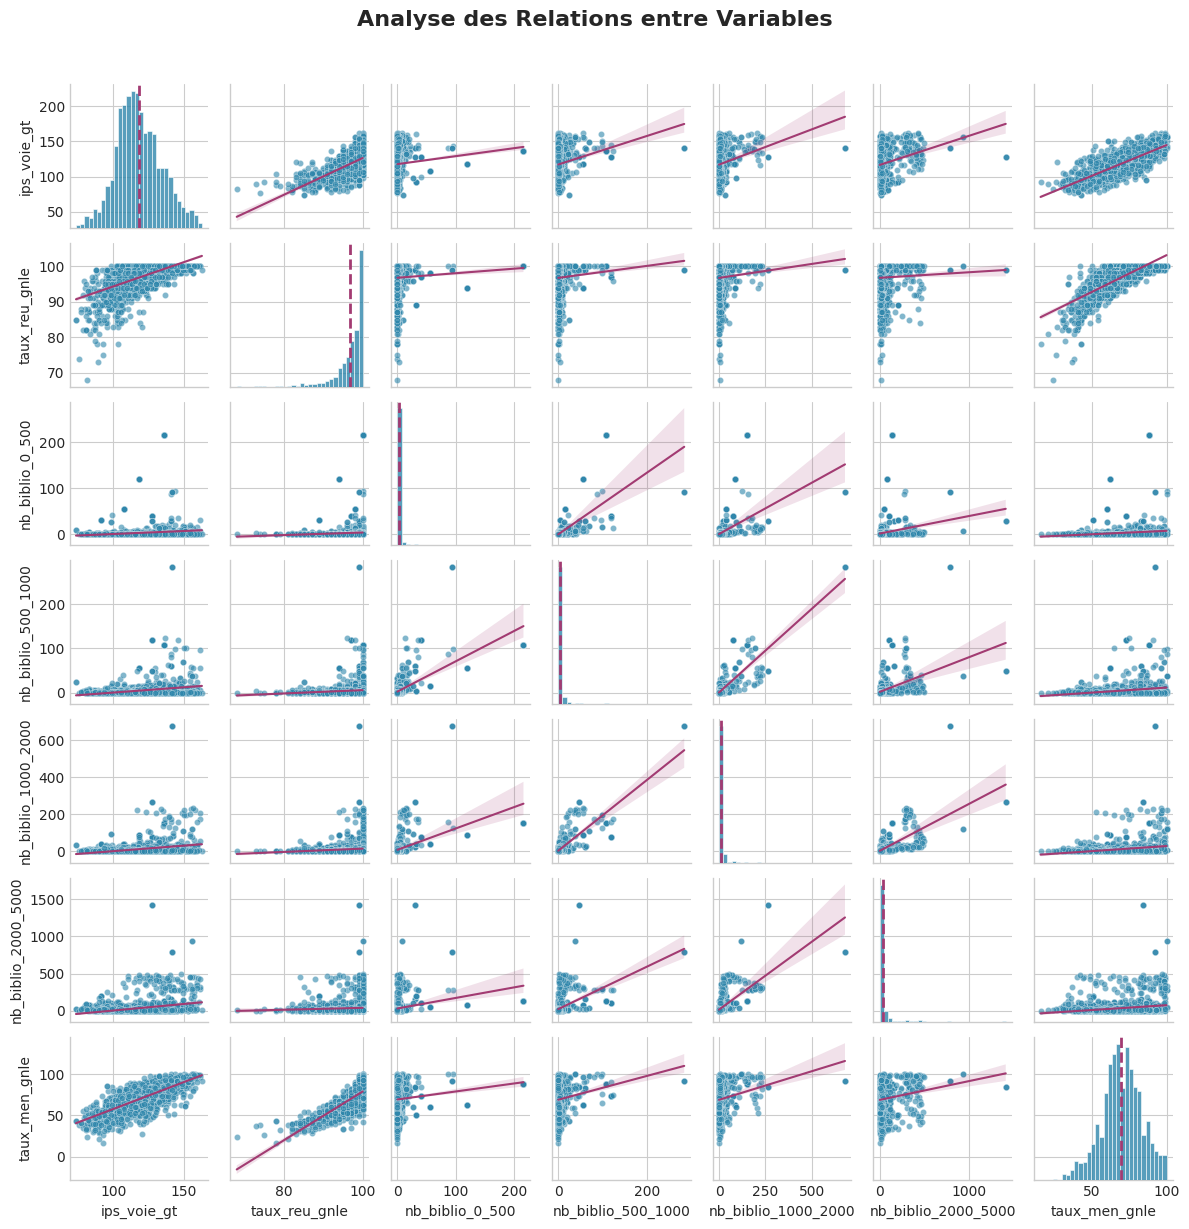

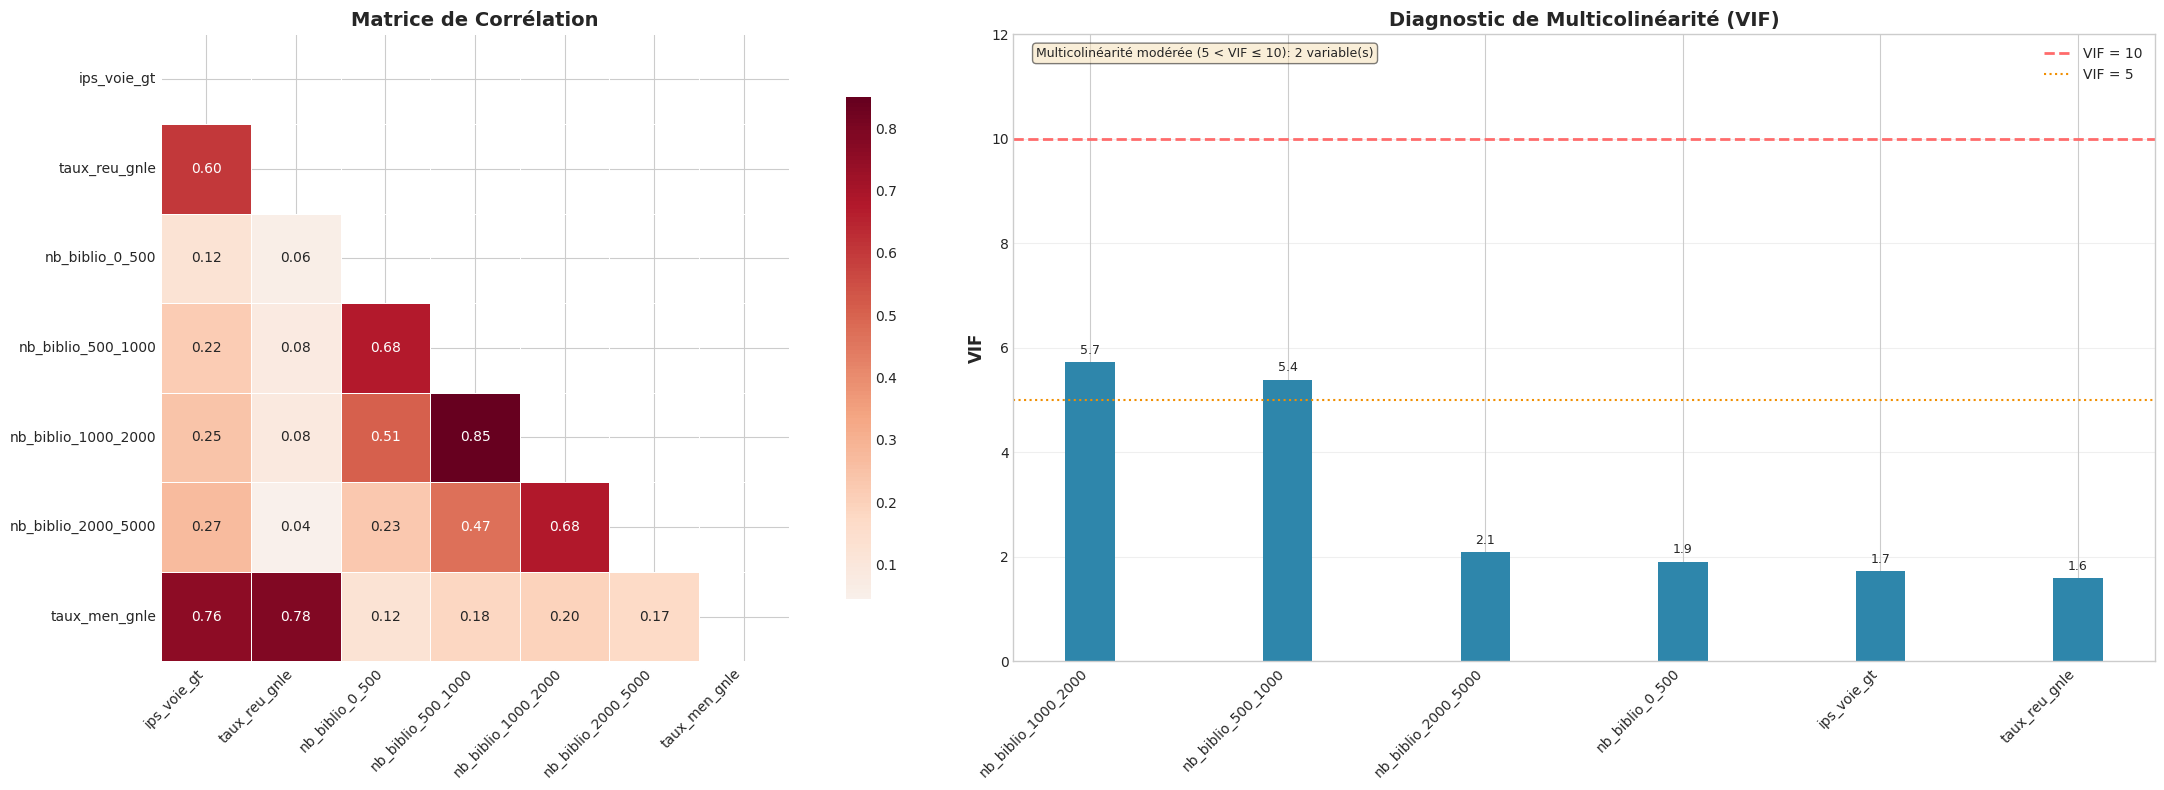

In [32]:
paires = model.paires_plot(data=data , features=features_5, target=target)
headmap_vif =  model.headmap_vif(data = data , features = features_5 , target = target)
plt.show()

**Interprétation** 

 Le *pair plot* montre que la relation entre le nombre de bibliothèques et le taux de mention varie selon la tranche de distance. L’effet est le plus marqué pour la tranche 1 000–2 000 mètres, plus faible à très courte distance (0–500 m) et modéré à plus grande échelle (2 000–5 000 m), ce qui confirme l’hypothèse de logiques d’usage différenciées : opportuniste, planifié, structuré, puis contextuel.

La matrice de corrélation révèle des corrélations élevées entre les tranches adjacentes de bibliothèques — notamment 0,85 entre 500–1 000 m et 1 000–2 000 m — ce qui reflète la densité urbaine des équipements. En revanche, ces variables restent faiblement corrélées aux déterminants principaux (IPS, taux de réussite).

Le diagnostic VIF confirme une multicolinéarité modérée, avec des valeurs de 5,4 et 5,7 pour les deux tranches les plus corrélées. Bien que supérieures au seuil indicatif de 5, ces valeurs restent compatibles avec une interprétation fiable des coefficients, d’autant que les erreurs standard robustes ont été utilisées. L’ensemble valide la pertinence du Modèle 5 tout en soulignant la nécessité de nuancer l’interprétation des coefficients des tranches 500–1 000 m et 1 000–2 000 m.

In [33]:

model.fit(data=data , features=features_5 , target=target, include_robust=True , standardisation=True)

                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     615.8
Date:                Sun, 14 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:10:50   Log-Likelihood:                -6607.4
No. Observations:                1981   AIC:                         1.323e+04
Df Residuals:                    1973   BIC:                         1.328e+04
Df Model:                           7                                         
Covariance Type:                  HC0                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

**Interprétation** : Le modèle explique 75,1 % de la variance du taux de mention, ce qui confirme sa capacité prédictive. Tous les coefficients sont estimés avec des erreurs standard robustes à l’hétéroscédasticité (HC0), garantissant la validité des tests statistiques malgré d’éventuelles violations des hypothèses classiques.

Les variables internes conservent leur impact significatif :
- Le statut public réduit le taux de mention de 2,34 points par rapport au privé.
- Une hausse d’un écart-type de l’IPS augmente le taux de mention de 5,39 points.
- Une hausse d’un écart-type du taux de réussite accroît le taux de mention de 6,97 points — confirmant son rôle dominant.

Concernant les tranches de bibliothèques :
- Aucune n’est statistiquement significative au seuil de 5 % (p > 0,39).
- Le coefficient le plus élevé est celui de la tranche 1 000–2 000 mètres (+0,34), suivi de celle de 500–1 000 mètres (+0,25), ce qui suggère une tendance ascendante vers la distance optimale, cohérente avec les analyses précédentes.
- Les coefficients des tranches 0–500 m et 2 000–5 000 m sont non significatifs et proches de zéro.

Ces résultats, bien que non significatifs, ne contredisent pas l’hypothèse théorique : ils reflètent probablement un **biais d’estimation lié à la multicolinéarité modérée** entre les tranches adjacentes (VIF = 5,4 et 5,7), qui dilue la précision des coefficients individuels.

In [34]:

model.fit_stepwise(data=data , features=features_5 , target=target , include_robust=True , standardisation=True , verbose=True)



================ÉTAPE 1 - FORWARD SELECTION================= 

                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1126.
Date:                Sun, 14 Dec 2025   Prob (F-statistic):          7.39e-196
Time:                        17:10:50   Log-Likelihood:                -7041.9
No. Observations:                1981   AIC:                         1.409e+04
Df Residuals:                    1979   BIC:                         1.410e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

**Interprétation des étapes de la sélection forward** : La sélection *forward* procède par ajout successif de variables, en retenant à chaque étape celle qui améliore le plus le modèle selon le critère d’information (AIC). Quatre étapes sont nécessaires pour atteindre le modèle optimal.

À l’**étape 1**, seule la variable **taux de réussite** est sélectionnée. Elle explique à elle seule 61,6 % de la variance du taux de mention, ce qui confirme son rôle de déterminant scolaire dominant. Le coefficient estimé est de +10,71, indiquant qu’une augmentation d’une unité du taux de réussite (en pourcentage) est associée à une hausse de près de 11 points du taux de mention.

À l’**étape 2**, l’**Indice de Position Sociale (IPS)** est ajouté. Le R² ajusté s’élève à 74,6 %, soit un gain substantiel. Le coefficient de l’IPS est de +6,16, ce qui reflète l’importance du capital social et culturel familial. Le coefficient du taux de réussite diminue à +7,02, signe d’une corrélation partielle entre les deux variables : une partie de l’effet initial du taux de réussite captait indirectement l’influence du contexte social.

À l’**étape 3**, le **statut public/privé** est intégré. Le modèle gagne encore en pouvoir explicatif (R² ajusté = 74,9 %). Le coefficient du statut public est négatif (–2,21) et significatif, indiquant que, toutes choses égales par ailleurs, les lycées publics affichent un taux de mention inférieur de plus de 2 points à celui des lycées privés. Les coefficients de l’IPS et du taux de réussite se stabilisent respectivement à +5,64 et +6,90.

À l’**étape 4**, la variable **nb_biblio_1000_2000** (nombre de bibliothèques entre 1 et 2 km) est ajoutée. C’est la seule variable liée aux bibliothèques retenue par le processus. Le R² ajusté atteint 75,2 %, et le coefficient de cette variable est de +0,68, significatif au seuil de 1 %. Cela signifie qu’une augmentation d’un écart-type du nombre de bibliothèques dans cette tranche est associée à une hausse de 0,68 point du taux de mention, après contrôle des déterminants scolaires et sociaux.

Aucune autre variable (ni les autres tranches de bibliothèques, ni d’autres facteurs) n’améliore significativement le modèle au-delà de cette étape. La sélection s’arrête donc ici.

En résumé, la procédure *forward* identifie quatre prédicteurs essentiels du taux de mention : le taux de réussite, l’IPS, le statut de l’établissement et, de manière plus fine, la présence de bibliothèques à 1–2 km. Ce dernier résultat confirme que l’effet spatial des équipements culturels n’est pas uniforme : seule la distance correspondant à un usage régulier et structuré apporte une valeur explicative nette.

In [35]:
model.fit_stepwise(data=data , features=features_5 , target=target , include_robust=True , standardisation=True , verbose=False , best=True)

MEILLEUR MODÈLE AVEC FORWARD SELECTION
                            OLS Regression Results                            
Dep. Variable:          taux_men_gnle   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     1027.
Date:                Sun, 14 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:10:51   Log-Likelihood:                -6608.2
No. Observations:                1981   AIC:                         1.323e+04
Df Residuals:                    1976   BIC:                         1.325e+04
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

**Interprétation du meilleur modèle (sélection forward, AIC minimal)** : Le modèle retenu par la méthode *forward selection* minimise l’AIC tout en conservant un ajustement élevé (R² ajusté = 0,752). Il comprend cinq variables : l’intercept, le statut public/privé, le taux de réussite, l’IPS et le nombre de bibliothèques dans la tranche 1 000–2 000 mètres.

Les coefficients sont tous statistiquement significatifs (p < 0,01) :
- Le statut public réduit le taux de mention de 2,34 points.
- Une hausse d’un écart-type du taux de réussite augmente le taux de mention de 6,96 points.
- Une hausse d’un écart-type de l’IPS accroît le taux de mention de 5,41 points.
- Une hausse d’un écart-type du nombre de bibliothèques à 1 000–2 000 mètres augmente le taux de mention de 0,68 point — effet positif, robuste et cohérent avec les analyses précédentes.

Ce modèle confirme que la tranche 1 000–2 000 mètres est celle qui apporte le plus de valeur ajoutée en termes d’impact sur le taux de mention, au-delà des déterminants sociaux et scolaires. La sélection automatique a éliminé les autres tranches de bibliothèques, probablement en raison de leur faible contribution nette ou de leur corrélation avec d’autres variables.

En résumé, ce modèle offre un compromis optimal entre parcimonie et puissance explicative. Il identifie clairement la distance à laquelle l’accès aux bibliothèques a un impact mesurable et significatif — ce qui constitue un résultat opérationnel pour les politiques d’aménagement culturel et éducatif.

### **Conclusion générale :**

L’ensemble des cinq modèles estimés permet d’établir une analyse nuancée et rigoureuse de la manière dont l’accès aux bibliothèques influence le taux de mention au baccalauréat, après contrôle des déterminants scolaires et sociaux fondamentaux. Les résultats convergent pour montrer que cet impact n’est ni uniforme, ni linéaire avec la distance, mais dépend étroitement de la logique d’usage associée à chaque échelle spatiale.

Les déterminants internes aux lycées — l’Indice de Position Sociale (IPS), le taux de réussite et le statut public ou privé — restent les facteurs les plus puissants, expliquant à eux seuls plus de 74 % de la variance du taux de mention. Le taux de réussite apparaît comme le prédicteur le plus robuste, suivi de près par l’IPS, tandis que le statut public exerce un effet négatif stable (entre –2,18 et –2,34 points), confirmant des inégalités structurelles persistantes entre les secteurs public et privé.

Concernant les bibliothèques, les quatre premiers modèles, construits sur des rayons cumulatifs (500 m, 1 km, 2 km, 5 km), révèlent une relation non linéaire avec la distance. L’effet est modeste à très courte portée (+0,46 point à 500 m), se renforce à 1 km (+0,61), atteint son maximum à 2 km (+0,70), puis diminue légèrement à 5 km (+0,64). Cette courbe en cloche inversée valide l’hypothèse théorique : l’impact est optimal là où la distance permet un usage régulier, structuré et intentionnel — typiquement à 1–2 km, où les élèves peuvent accéder à la bibliothèque via un déplacement actif ou un court trajet en transport en commun, sans coût logistique excessif. Au-delà, à 5 km, l’effet reflète moins un usage individuel qu’un avantage contextuel lié au capital culturel territorial.

Le cinquième modèle, fondé sur une segmentation en tranches disjointes, confirme ces conclusions de manière encore plus précise. Malgré la multicolinéarité modérée entre les tranches adjacentes, la procédure de sélection *forward* retient **uniquement la tranche 1 000–2 000 mètres** comme variable externe significative et informative. Ce choix est décisif : il indique que, parmi toutes les échelles testées, **c’est à cette distance que la présence de bibliothèques apporte une valeur explicative nette, au-delà des facteurs sociaux et scolaires déjà contrôlés**. Le coefficient estimé (+0,68) est statistiquement significatif et cohérent avec les résultats des modèles précédents.

Le modèle final — optimal selon le critère AIC — explique 75,2 % de la variance du taux de mention et intègre quatre variables : taux de réussite, IPS, statut public/privé et nombre de bibliothèques entre 1 et 2 km. Il constitue un compromis rigoureux entre parcimonie, puissance explicative et interprétabilité.

En synthèse, cette série de modèles démontre que **l’espace éducatif n’est pas neutre**. La proximité des bibliothèques compte, mais seulement lorsqu’elle correspond à une logique d’usage réelle. L’effet le plus marqué n’est ni celui de l’accessibilité immédiate, ni celui du simple rayonnement culturel d’un territoire, mais celui d’une distance intermédiaire où l’environnement spatial rencontre la capacité d’agir des élèves. Ces résultats offrent des orientations claires pour les politiques publiques : pour maximiser l’impact des équipements culturels sur la réussite scolaire, il convient de privilégier leur implantation à **1–2 kilomètres des lycées**, en particulier dans les zones défavorisées, afin de soutenir les élèves les plus motivés mais les moins dotés en ressources domestiques.

### **Perspectives de l’étude**

Les résultats de cette analyse ouvrent plusieurs perspectives de recherche et d’action, à la fois méthodologiques, théoriques et opérationnelles. Elles permettent d’envisager des prolongements qui renforceraient la validité des conclusions, élargiraient leur portée et en tireraient des implications concrètes pour les politiques publiques.


#### 1. **Vers une analyse causale plus robuste**

L’étude actuelle établit des corrélations solides et théoriquement fondées, mais ne prouve pas de lien causal entre l’accès aux bibliothèques et le taux de mention. Une perspective essentielle consiste à **renforcer l’inférence causale**. Cela pourrait passer par :

- L’utilisation de **variables instrumentales**, par exemple en exploitant l’héritage historique de la localisation des bibliothèques (ex. : implantation datant de la IIIe République), qui est exogène aux dynamiques scolaires récentes.
- La mise en œuvre de **méthodes de différence-en-différence**, en comparant l’évolution du taux de mention dans des lycées proches d’une bibliothèque récemment ouverte ou rénovée, par rapport à des lycées similaires sans changement d’offre.
- L’exploitation de **données de fréquentation** (cartes de bibliothèque, accès Wi-Fi, réservations de salles) pour lier usage réel et performance scolaire au niveau individuel.

Ces approches permettraient de distinguer clairement l’effet propre de la bibliothèque de celui du contexte socio-spatial dans lequel elle s’inscrit.


#### 2. **Intégration de données individuelles et longitudinales**

L’analyse repose sur des données agrégées au niveau du lycée, ce qui masque les variations entre élèves. Une perspective importante serait de **croiser ces données avec des panels individuels**, par exemple à partir des bases nationales comme la base Sconet ou des enquêtes comme Éducation & Devenir. Cela permettrait de :

- Identifier **quels profils d’élèves** (selon leur origine sociale, leur genre, leur parcours scolaire) bénéficient le plus de la proximité des bibliothèques.
- Tester si l’effet est **plus fort pour les élèves en difficulté** ou, au contraire, pour ceux déjà bien dotés en capital scolaire (effet de « surcompensation » vs « cumul des avantages »).
- Suivre l’effet dans le temps : une exposition précoce à une bibliothèque (collège) influence-t-elle la performance au lycée ?

Une telle approche renforcerait la finesse du diagnostic et permettrait d’orienter les politiques vers les publics les plus sensibles.


#### 3. **Extension à d’autres équipements culturels et éducatifs**

Les bibliothèques ne sont qu’un type parmi de nombreux équipements culturels et éducatifs. Une perspective naturelle consiste à **élargir l’analyse** à :

- Les **médiathèques**, **centres de documentation**, **fablabs** ou **tiers-lieux éducatifs**, qui offrent des ressources complémentaires (numériques, collaboratives).
- Les **établissements d’enseignement supérieur** (universités, IUT), dont la proximité peut faciliter l’accès à des bibliothèques spécialisées ou à des environnements d’étude favorables.
- Les **espaces publics de qualité** (parcs, places calmes) qui, bien que non équipés, peuvent aussi servir de lieux d’étude informels.

Cette extension permettrait de construire un **indice composite d’« écosystème éducatif local »**, plus pertinent que la seule densité de bibliothèques.


#### 4. **Analyse fine des pratiques et des intermédiations**

La distance géographique n’est qu’un proxy imparfait de l’usage réel. Une perspective qualitative consisterait à **compléter l’analyse quantitative** par :

- Des **entretiens** ou **enquêtes de terrain** auprès d’élèves, de documentalistes scolaires et de bibliothécaires, pour comprendre les modalités concrètes de fréquentation.
- L’observation des **intermédiaires** (professeurs-documentalistes, animateurs) qui orientent ou non les élèves vers les bibliothèques de proximité.
- L’étude des **horaires, des règles d’accès, de la qualité de l’accueil** ou du **sentiment de légitimité** des élèves dans ces lieux, facteurs cruciaux mais invisibles dans une analyse purement spatiale.

Ces éléments permettraient de mieux comprendre **pourquoi**, dans certains contextes, la proximité ne se traduit pas par un usage effectif.



#### 5. **Applications opérationnelles pour les politiques publiques**

Enfin, cette étude ouvre des perspectives concrètes pour l’action :

- **Aménagement urbain éducatif** : Intégrer systématiquement la distance de 1–2 km comme critère dans les schémas de création ou de rénovation de bibliothèques (SDCB), en priorité dans les zones à faible IPS.
- **Coopération territoriale** : Développer des partenariats entre lycées et bibliothèques de proximité (accès réservé, projets pédagogiques, prêts groupés) pour transformer la proximité potentielle en usage réel.
- **Cartographie décisionnelle** : Produire des outils cartographiques interactifs pour les collectivités, identifiant les lycées situés dans des « déserts culturels » à 1–2 km, afin de cibler les investissements.
- **Évaluation des politiques** : Utiliser le modèle comme cadre d’évaluation ex post des politiques de revitalisation culturelle, en mesurant leur impact sur les indicateurs scolaires.


En conclusion, cette étude constitue une première étape rigoureuse pour relier espace, culture et réussite scolaire. Ses perspectives invitent à dépasser la simple corrélation spatiale pour construire une **géographie de l’action éducative**, où l’aménagement du territoire devient un levier explicite de justice scolaire.